[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)

# **CAP-421 Aprendizado Profundo (*Deep Leraning*)**
## **OTIMIZANDO REDES NEURAIS RECORRENTES PARA PREVISÃO DE CHUVA COM DADOS DESBALANCEADOS**



**Docentes:** *Dr. Valdivino Alexandre de Santiago Junior, Dr. Elcio Hideiti Shiguemori e Dr. Thales Sehn Körti*

**Discente:** *Lourenço José Cavalcante Neto*

---



## Resumo
*A previsão de chuva a curto prazo é essencial para diversos setores, como a agricultura e companhias aéreas, entre outros. Nesse contexto, modelos de previsão baseados em Inteligência Artificial (IA) têm se destacado. No entanto, um problema recorrente está relacionado à qualidade dos dados utilizados no treinamento desses modelos, especialmente no caso de dados de precipitação. Em [2], foi realizado um estudo sobre o desbalanceamento dados meteorológicos, associados a diferentes sistemas precipitantes observados [9], e sua influência na capacidade preditiva de um modelo de previsão de chuva usando uma rede neural MLP (Multilayer Perceptron). O desbalanceamnerto pode levar a estimativas enviesadas, favorecendo certos tipos de chuva em detrimento de outros. Por exemplo, chuvas mais fracas podem ser sobre-representadas em comparação com chuvas mais fortes, que são menos frequentes. Embora o estudo tenha evidenciado a importância de se utilizar dados confiáveis para o treinamento do modelo, MLPs não conseguem capturar adequadamente as dependências temporais e os padrões sequenciais dos dados. Isso sugere a necessidade de investigações adicionais, em que uma abordagem usando métodos de aprendizado profundo (Deep Learnig) pode ser um ponto de partida. Assim, o objetivo deste trabalho será explorar um tipo específico de rede neural recorrente, especificamente uma LSTM (Long Short-Term Memory) [5], cuja arquitetura é mais adequada para lidar com dependências de longo prazo em séries temporais [8]. Será avaliado o desempenho da LSTM em comparação aos resultados obtidos com a MLP em [2], no mesmo contexto de dados, em que pesos serão aplicados à perda do modelo para cada amostra durante o treinamento, levando em consideração a intensidade da chuva (mm/h). Os dados estão em formato tabular e foram coletados por quatro sensores meteorológicos: um disdrômetro de impacto Joss-Waldvogel [6], um disdrômetro a laser PARSIVEL2 (Particle Size and Velocity) [7], um pluviômetro automático [4] e um radiômetro de micro-ondas terrestre [3]. Os sensores estão instalados no experimento de campo campina, que faz parte do projeto Amazon Tall Tower Observatory (ATTO) [1].*

## **Importando módulos e bibliotecas**
Em Python, as bibliotecas são importadas convencionalmente, conforme/aplicado na célula abaixo:

In [2]:
# Importações de bibliotecas
import os
import glob
import pathlib
import random
import math
import calendar
import datetime
import numpy as np
import pandas as pd

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Bibliotecas de pré-processamento e métricas
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                             f1_score, roc_auc_score, accuracy_score)
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Bibliotecas de deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers  # Import corrigido

# Configuração de estilo do matplotlib
plt.rcParams['font.family'] = 'serif'

#numpy matplotlib pandas seaborn scikit-learn tensorflow

print('Execução do código concluída.')

Execução do código concluída.


## **Conjunto de dados**
Como mencionado anteriormente, os dados foram coletados por quatro sensores meteorológicos: um disdrômetro de impacto Joss-Waldvogel [6], um disdrômetro a laser PARSIVEL2 (Particle Size and Velocity) [7], um pluviômetro automático [4] e um radiômetro de micro-ondas terrestre [3]

Os dados abrangem o período de outubro de 2020 a novembro de 2023.

In [3]:
file_path = '/kaggle/input/dataset-atto-campina-amazonia-v3/dataset_atto_campina_amazonia_v3.csv'
df_complete = pd.read_csv(file_path, sep=';', index_col=0)
# Garantir que o índice seja datetime após carregar o CSV
df_complete.index = pd.to_datetime(df_complete.index)
print('Execução do código concluída.')

Execução do código concluída.


In [4]:
df_complete.head(n=3)

new_Tamb_k  new_Rh_percent  new_Pres_mb   new_Tir_K  \
Datetime                                                                   
2021-07-27 18:00:00  294.946522       55.664565  1007.527391  300.105435   
2021-07-27 19:00:00  295.071731       54.720962  1006.885000  300.469615   
2021-07-27 20:00:00  295.091667       55.201500  1006.325000  300.736000   

                     new_Ch_22_234  new_Ch_22_500  new_Ch_23_034  \
Datetime                                                           
2021-07-27 18:00:00     298.461696      298.37763     298.679326   
2021-07-27 19:00:00     298.509308      298.50750     298.757942   
2021-07-27 20:00:00     298.624933      298.59120     298.920800   

                     new_Ch_23_834  new_Ch_25_000  new_Ch_26_234  ...  \
Datetime                                                          ...   
2021-07-27 18:00:00     298.544217     298.500065     298.564957  ...   
2021-07-27 19:00:00     298.618288     298.732077     298.645288  ...   
2021-07-27 20:00:00     298.747850     298.779467     298.751300  ...   

                     new_Ch_54_400  new_Ch_54_940  new_Ch_55_500  \
Datetime                                                           
2021-07-27 18:00:00     299.575196     299.649739     299.555804   
2021-07-27 19:00:00     299.629846     299.708885     299.567250   
2021-07-27 20:00:00     299.867067     299.794883     299.883500   

                     new_Ch_56_020  new_Ch_56_660  new_Ch_57_288  \
Datetime                                                           
2021-07-27 18:00:00     299.520826     299.671000     299.416978   
2021-07-27 19:00:00     299.863654     299.761442     299.678558   
2021-07-27 20:00:00     299.937283     299.907367     299.792733   

                     new_Ch_57_964  new_Ch_58_800  Mask_RR_mm_min  \
Datetime                                                            
2021-07-27 18:00:00     299.607913     299.418543             0.0   
2021-07-27 19:00:00     299.738231     299.784135             0.0   
2021-07-27 20:00:00     299.972033     300.036833             0.0   

                     Rainfall_mmh  
Datetime                           
2021-07-27 18:00:00           0.0  
2021-07-27 19:00:00           0.0  
2021-07-27 20:00:00           0.0  

[3 rows x 28 columns]

In [5]:
df_copy = df_complete.copy()
print('Execução do código concluída.')

Execução do código concluída.


In [6]:
df_copy.describe()


new_Tamb_k  new_Rh_percent   new_Pres_mb     new_Tir_K  \
count  20464.000000    20464.000000  20464.000000  20464.000000   
mean     299.239414       82.361303   1006.181217    269.059375   
std        3.893276       23.769482      2.259359     12.834090   
min      292.073000       -0.470000    997.423167    231.714667   
25%      296.368375       72.729917   1004.675000    258.214125   
50%      297.832333       93.824667   1006.181217    268.449500   
75%      301.454917       98.901469   1007.740417    279.611875   
max      312.867333       99.770000   1014.746667    302.823667   

       new_Ch_22_234  new_Ch_22_500  new_Ch_23_034  new_Ch_23_834  \
count   20464.000000   20464.000000   20464.000000   20464.000000   
mean       79.816521      77.336405      68.219835      62.222336   
std        30.426379      30.947488      32.084588      32.083624   
min       -83.862000      13.375000      -6.033667      14.851767   
25%        65.493742      62.977521      53.969847      48.997771   
50%        76.079200      73.415950      63.576765      56.337452   
75%        83.190354      80.958942      71.458677      62.691121   
max       298.624933     298.591200     298.920800     298.747850   

       new_Ch_25_000  new_Ch_26_234  ...  new_Ch_54_400  new_Ch_54_940  \
count   20464.000000   20464.000000  ...   20464.000000   20464.000000   
mean       40.791433      24.146327  ...     281.145085     290.107919   
std        34.915491      37.491470  ...       3.694576       2.826448   
min        -2.659400     -15.466917  ...      42.620000      46.323000   
25%        27.327758       9.999471  ...     279.842683     289.047076   
50%        33.288483      15.466267  ...     280.637650     289.957992   
75%        40.254950      22.130142  ...     281.543292     290.964662   
max       298.779467     298.751300  ...     299.867067     299.818333   

       new_Ch_55_500  new_Ch_56_020  new_Ch_56_660  new_Ch_57_288  \
count   20464.000000   20464.000000   20464.000000   20464.000000   
mean      293.034346     294.566858     295.382583     295.435582   
std         2.683398       2.725360       2.740464       2.826012   
min        43.610000      45.448000      45.024000      43.182000   
25%       292.002875     293.448017     294.235871     294.271533   
50%       292.965333     294.506400     295.326908     295.382950   
75%       293.976629     295.601358     296.460748     296.550096   
max       299.883500     301.352614     302.389317     302.550860   

       new_Ch_57_964  new_Ch_58_800  Mask_RR_mm_min  Rainfall_mmh  
count   20464.000000   20464.000000    20464.000000  20464.000000  
mean      295.959472     296.505094        0.379136      0.381010  
std         2.996505       3.127453        2.115175      2.117397  
min        45.724000      49.968000        0.000000      0.000000  
25%       294.695063     295.182521        0.000000      0.000000  
50%       295.866417     296.394975        0.000000      0.000000  
75%       297.169817     297.766146        0.000000      0.000000  
max       303.487367     304.255000       50.357757     50.357757  

[8 rows x 28 columns]

In [7]:
# Calculate NaN percentages for each column
nan_counts = df_copy.isna().sum()
nan_percentages = (nan_counts / len(df_copy)) * 100

# Drop columns with NaN percentage >= 100%
columns_to_drop = nan_percentages[nan_percentages >= 100].index
df_copy.drop(columns=columns_to_drop, inplace=True)
print('Execução do código concluída.')

Execução do código concluída.


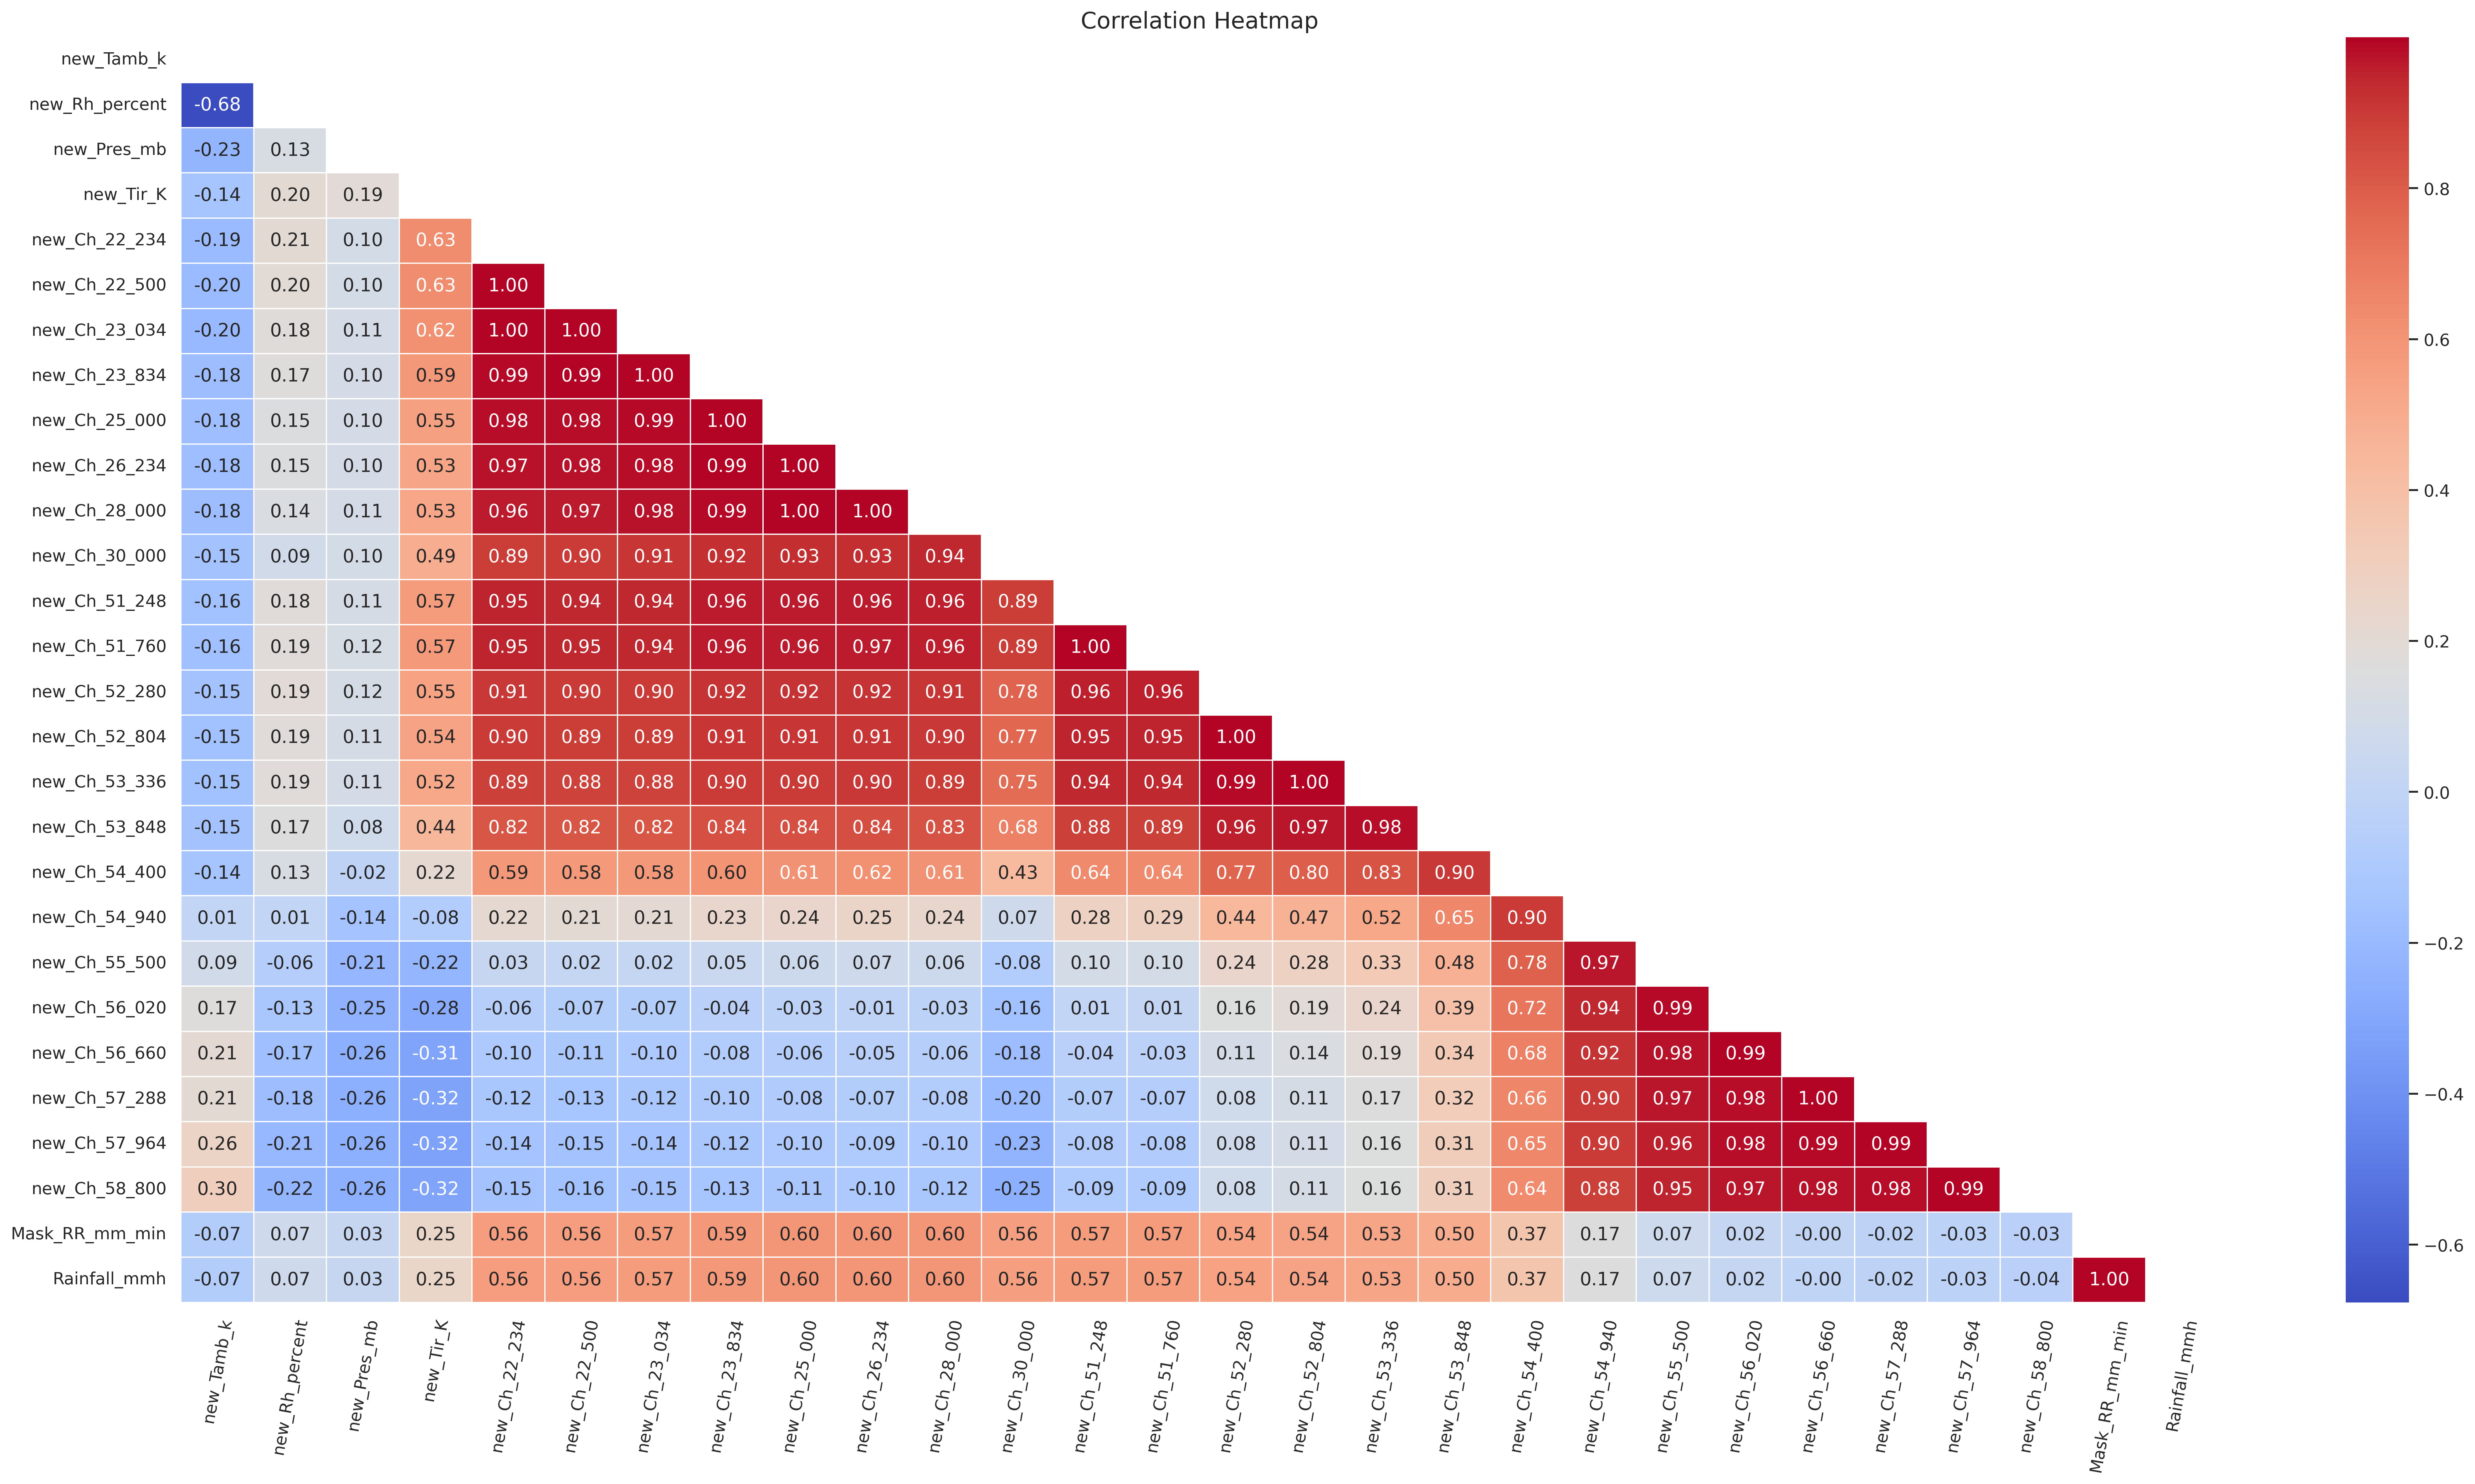

In [8]:
# Calcular a matriz de correlação diretamente em df_final

df_calc_corr = df_copy.loc[((df_copy['Rainfall_mmh'] >= 0))].copy()

correlation_matrix = df_calc_corr.corr(method='pearson') #spearman

# Configurar estilo para o gráfico
sns.set(style="white")

# Criar uma máscara para mostrar apenas a metade superior da matriz
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Obter os nomes das variáveis presentes no DataFrame
nomes_variaveis = df_calc_corr.columns

# Criar o gráfico de heatmap
plt.figure(figsize=(30, 15), dpi=350)
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, mask=mask)
plt.title('Correlation Heatmap', fontsize=15)
#plt.ylabel('Variáveis', fontsize=9)
#plt.xlabel('Variáveis', fontsize=9)

# Definir rótulos personalizados para os eixos Y e X com os nomes das variáveis
plt.yticks(np.arange(len(nomes_variaveis)) + 0.5, nomes_variaveis, fontsize=11, va='center')
plt.xticks(np.arange(len(nomes_variaveis)) + 0.5, nomes_variaveis, fontsize=11, rotation=80, ha='center')

plt.show()


In [9]:
df_final = df_copy.copy()
print('Execução do código concluída.')

Execução do código concluída.


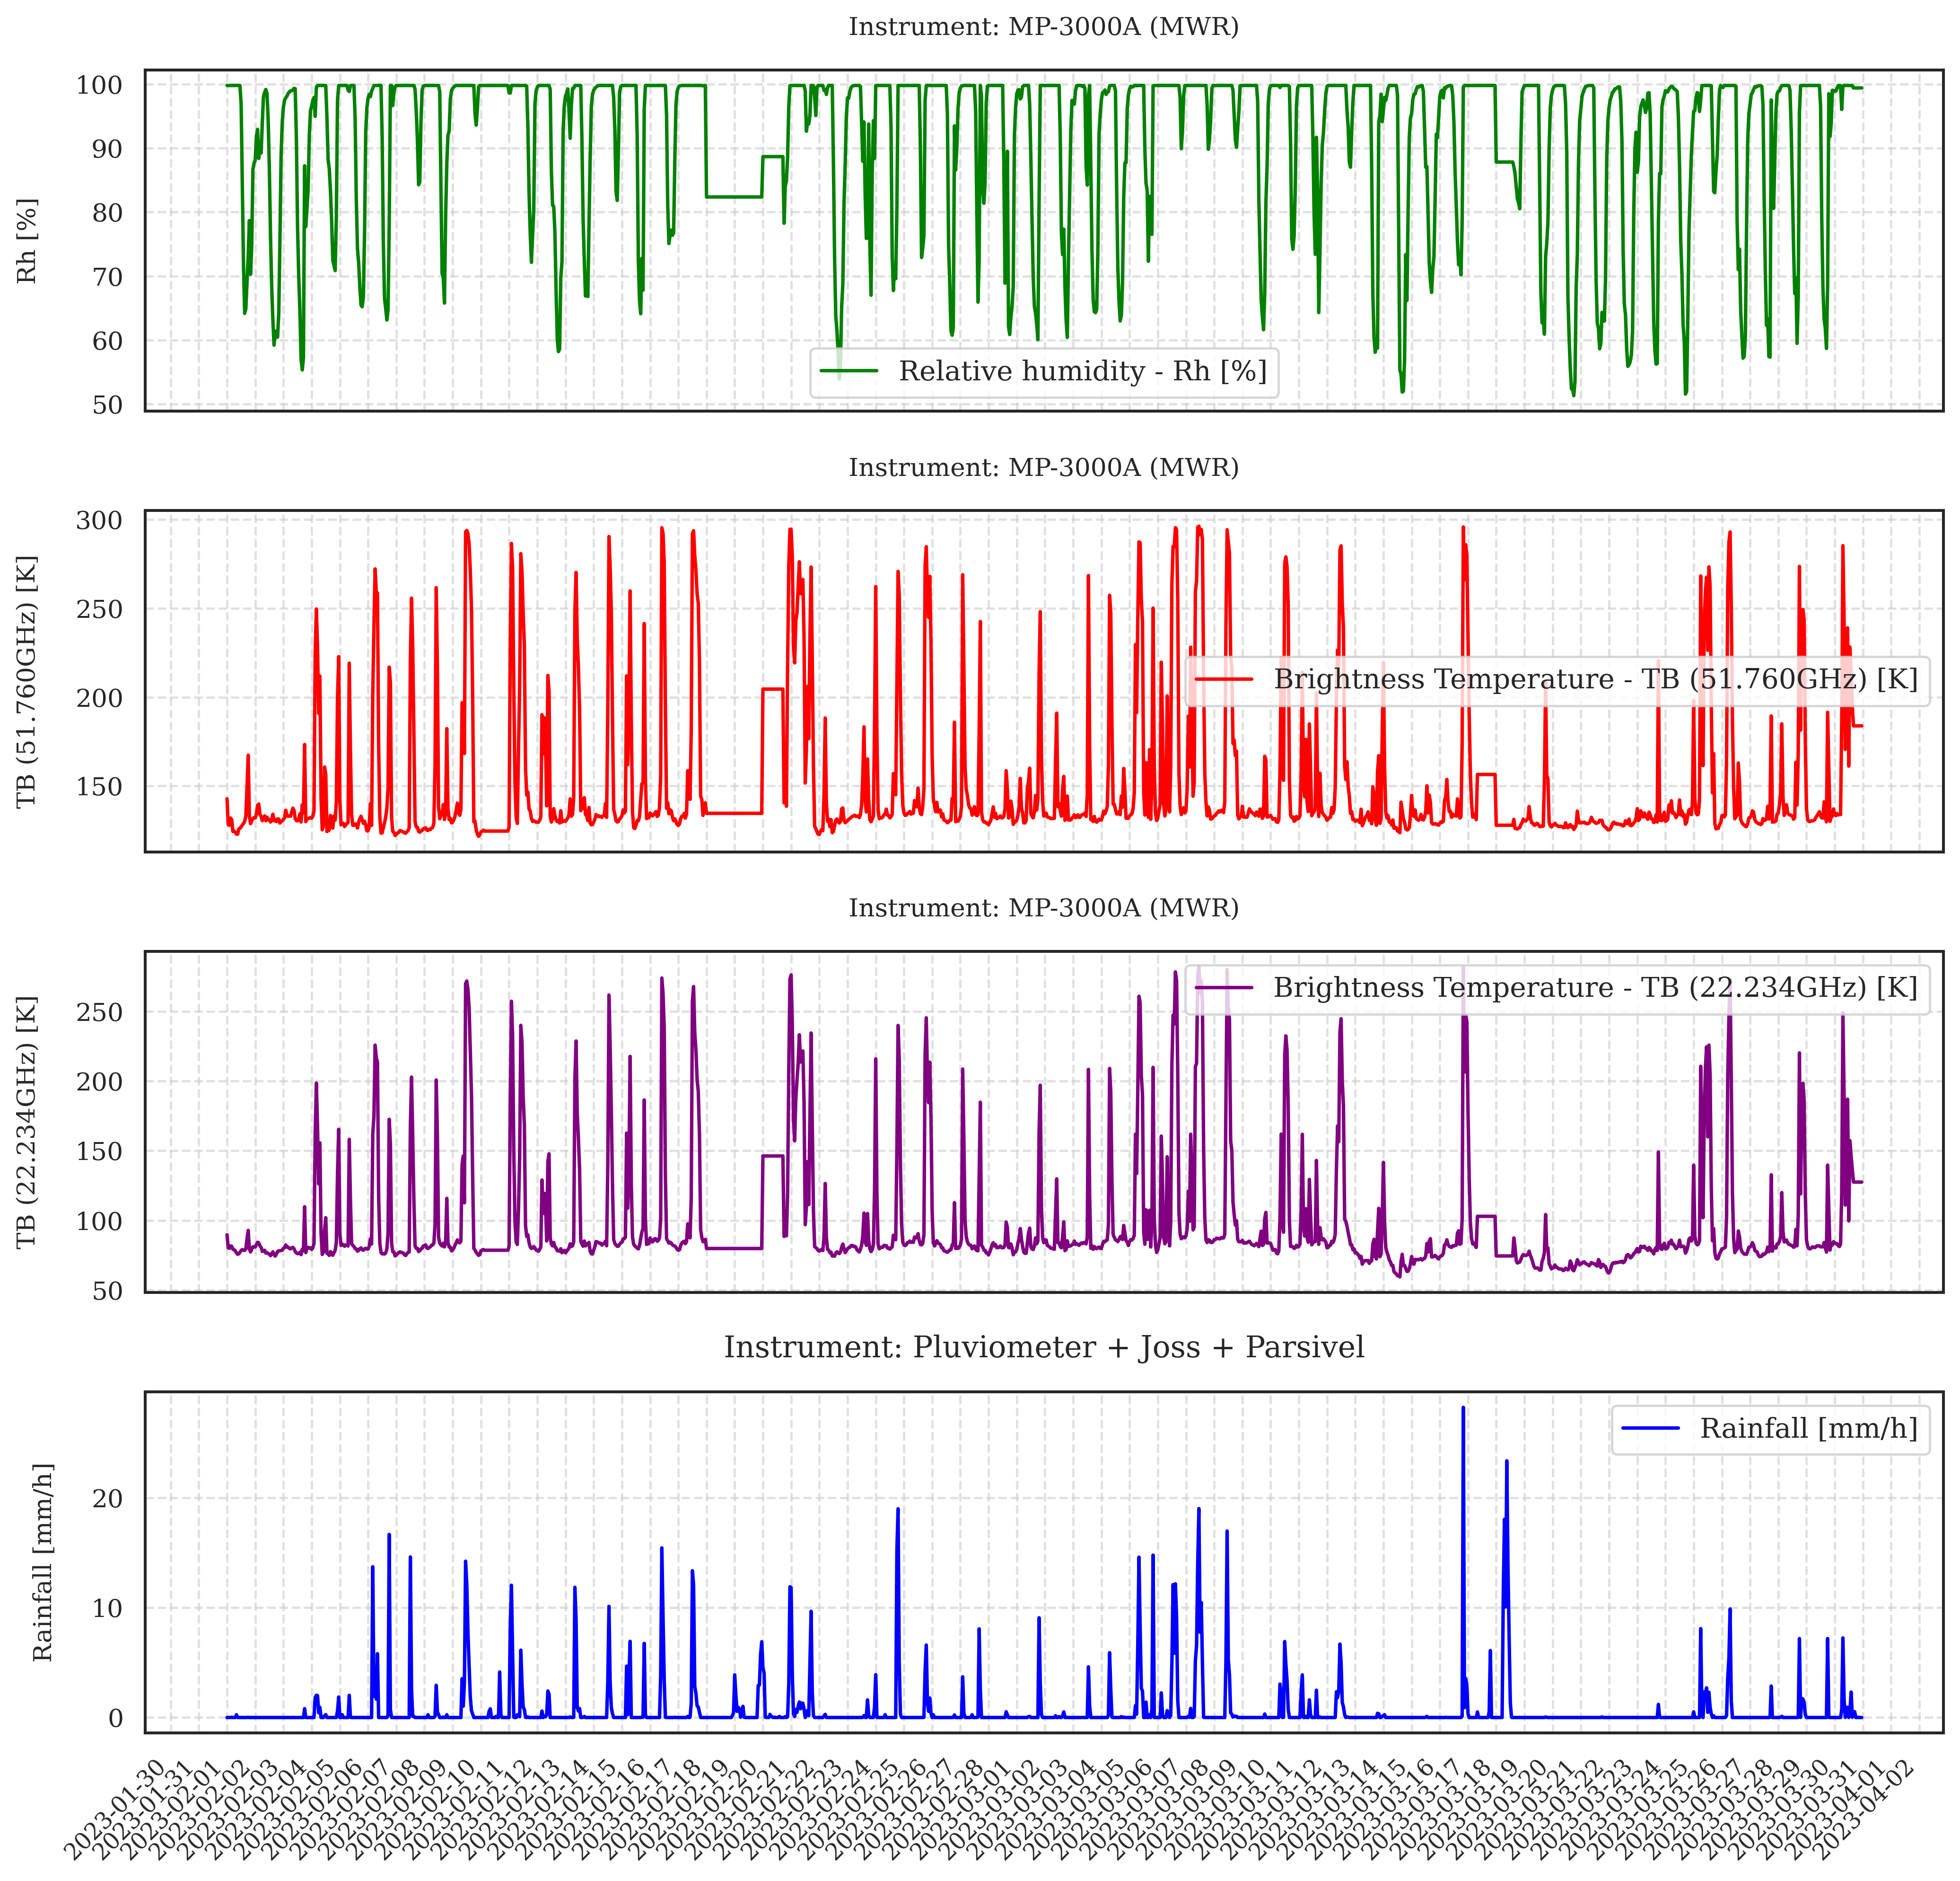

In [10]:
# Define the date range
start_date = '2023-02-01'
end_date = '2023-03-30'

# Filter the data for the specified period
df_filtered3 = df_final[start_date:end_date]

# Set the font family to a serif font
plt.rcParams['font.family'] = 'serif'

# Create the figure and subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 12), dpi=350, sharex=True)

# Plot the time series in each subplot
axes[0].plot(df_filtered3.index, df_filtered3['new_Rh_percent'], color='green', label='Relative humidity - Rh [%]')
axes[1].plot(df_filtered3.index, df_filtered3['new_Ch_51_760'], color='red', label='Brightness Temperature - TB (51.760GHz) [K]')
axes[2].plot(df_filtered3.index, df_filtered3['new_Ch_22_234'], color='purple', label='Brightness Temperature - TB (22.234GHz) [K]')
axes[3].plot(df_filtered3.index, df_filtered3['Rainfall_mmh'], color='blue', label='Rainfall [mm/h]')

# Add labels to the y-axes
axes[0].set_ylabel('Rh [%]', fontsize=11, labelpad=15)
axes[1].set_ylabel('TB (51.760GHz) [K]', fontsize=11, labelpad=15)
axes[2].set_ylabel('TB (22.234GHz) [K]', fontsize=11, labelpad=15)
axes[3].set_ylabel('Rainfall [mm/h]', fontsize=11, labelpad=15)

# Add titles to the subplots
axes[0].set_title('Instrument: MP-3000A (MWR)', fontsize=11, pad=15)
axes[1].set_title('Instrument: MP-3000A (MWR)', fontsize=11, pad=15)
axes[2].set_title('Instrument: MP-3000A (MWR)', fontsize=11, pad=15)
axes[3].set_title('Instrument: Pluviometer + Joss + Parsivel', fontsize=13, pad=15)

# Add legends
for ax in axes:
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

# Improve date formatting on the x-axis
axes[-1].xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=1))  # Display one date per day
axes[-1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

# Rotate the labels for better readability
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=10)

# Adjust layout to avoid label overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()


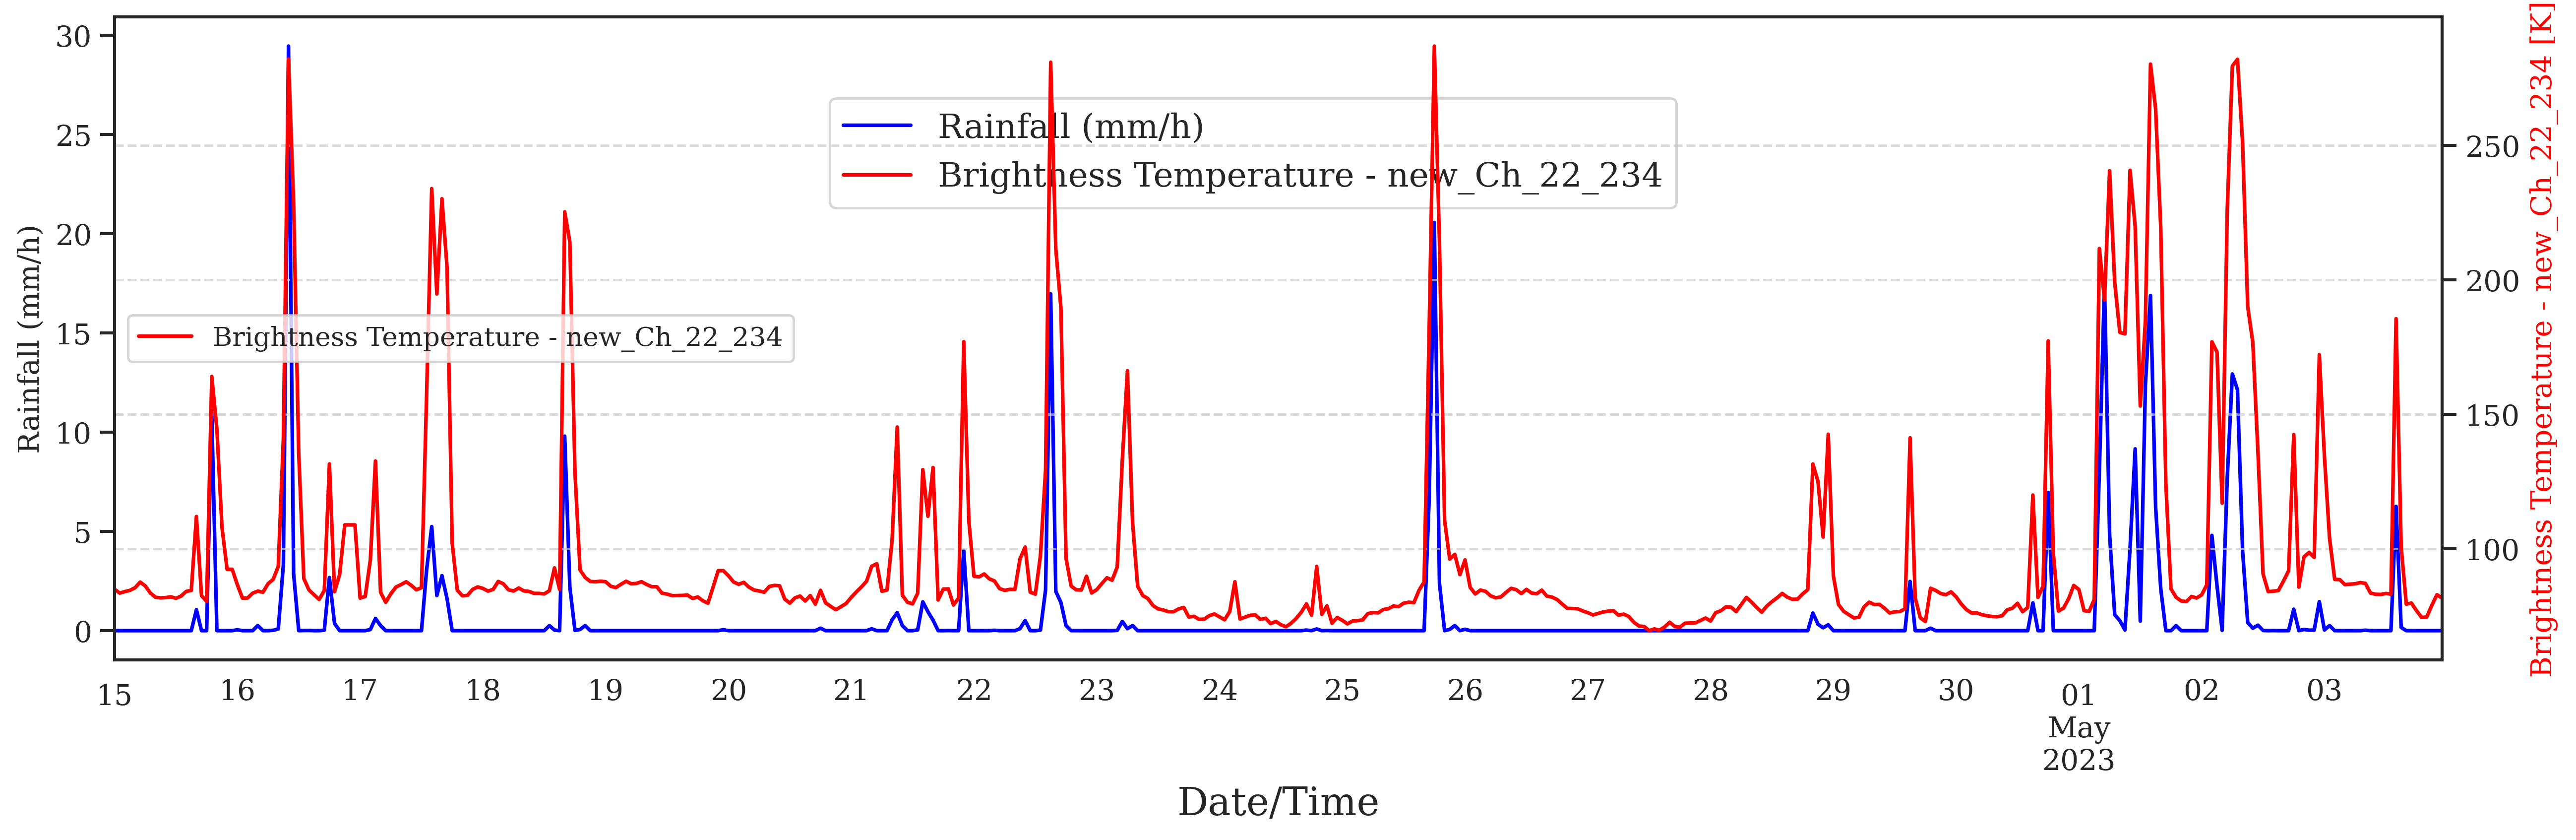

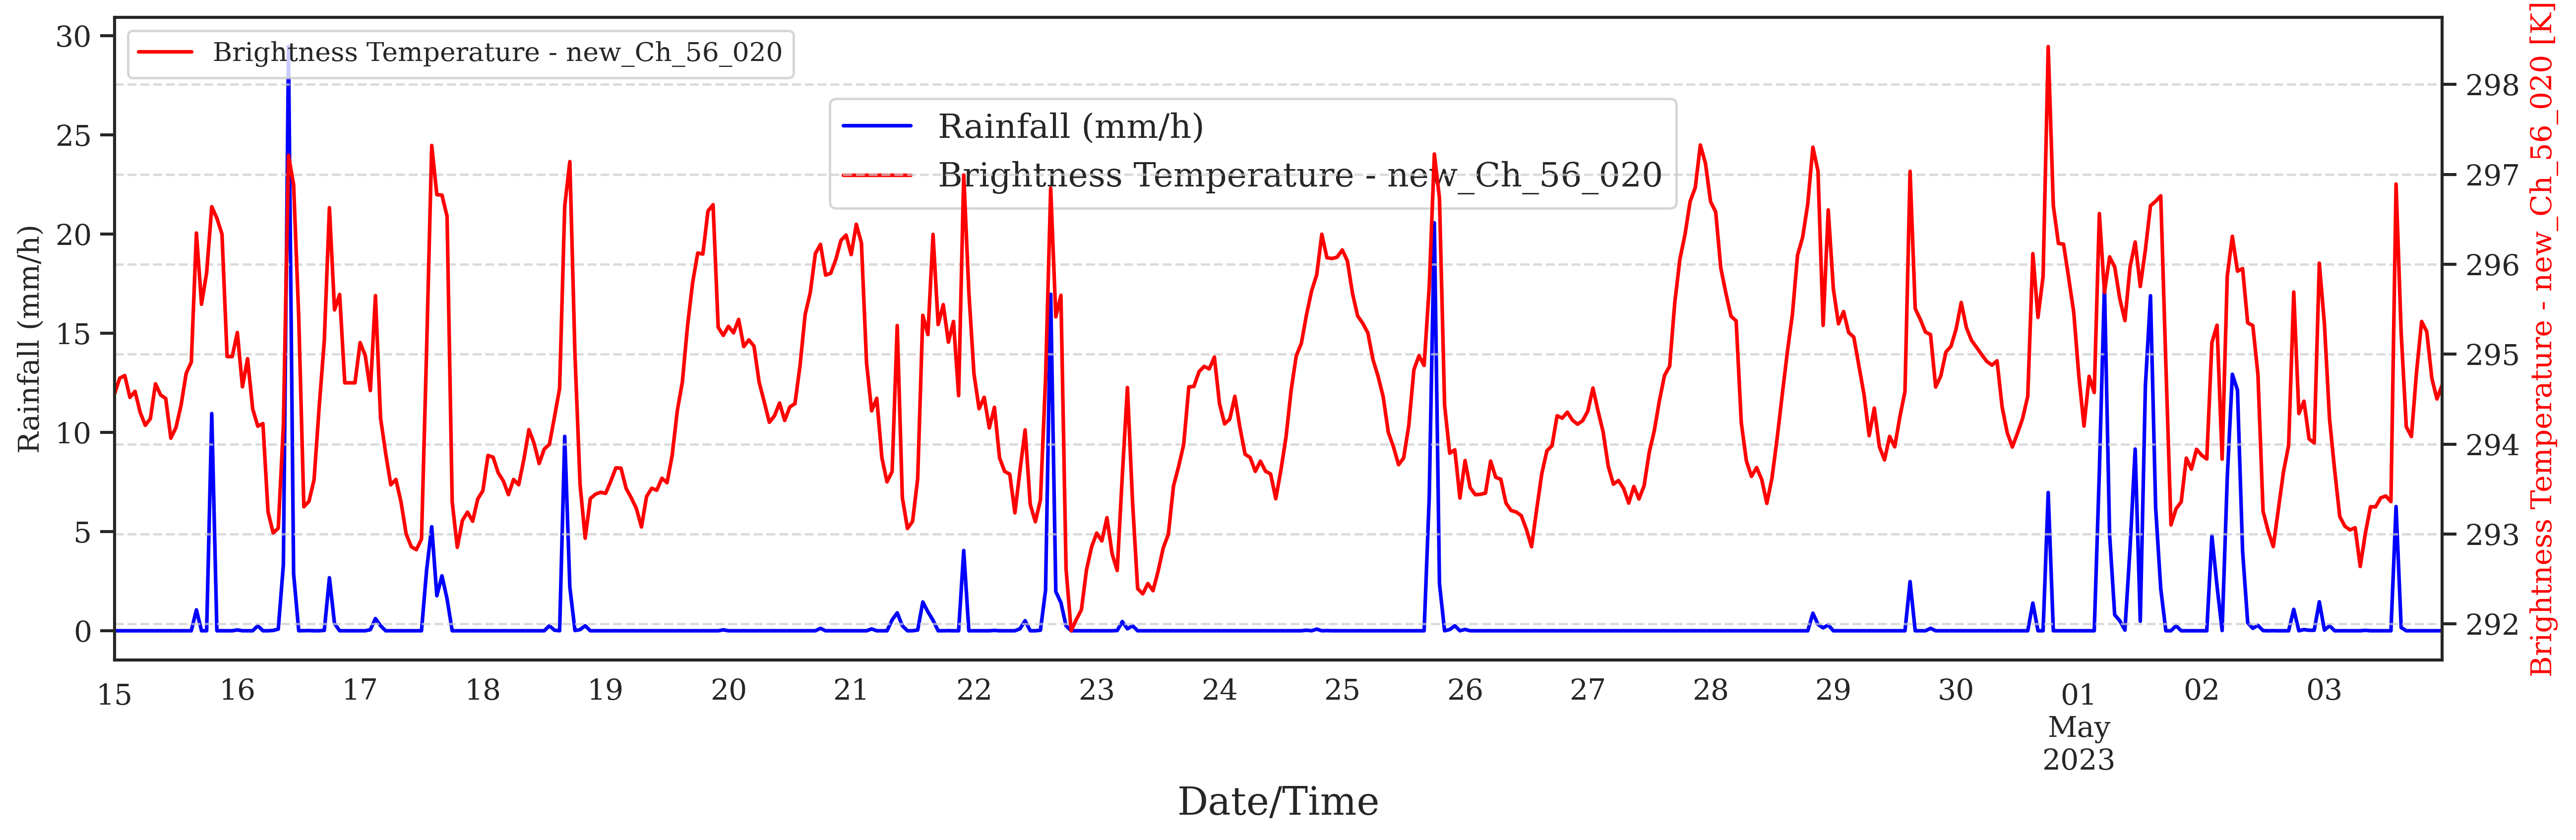

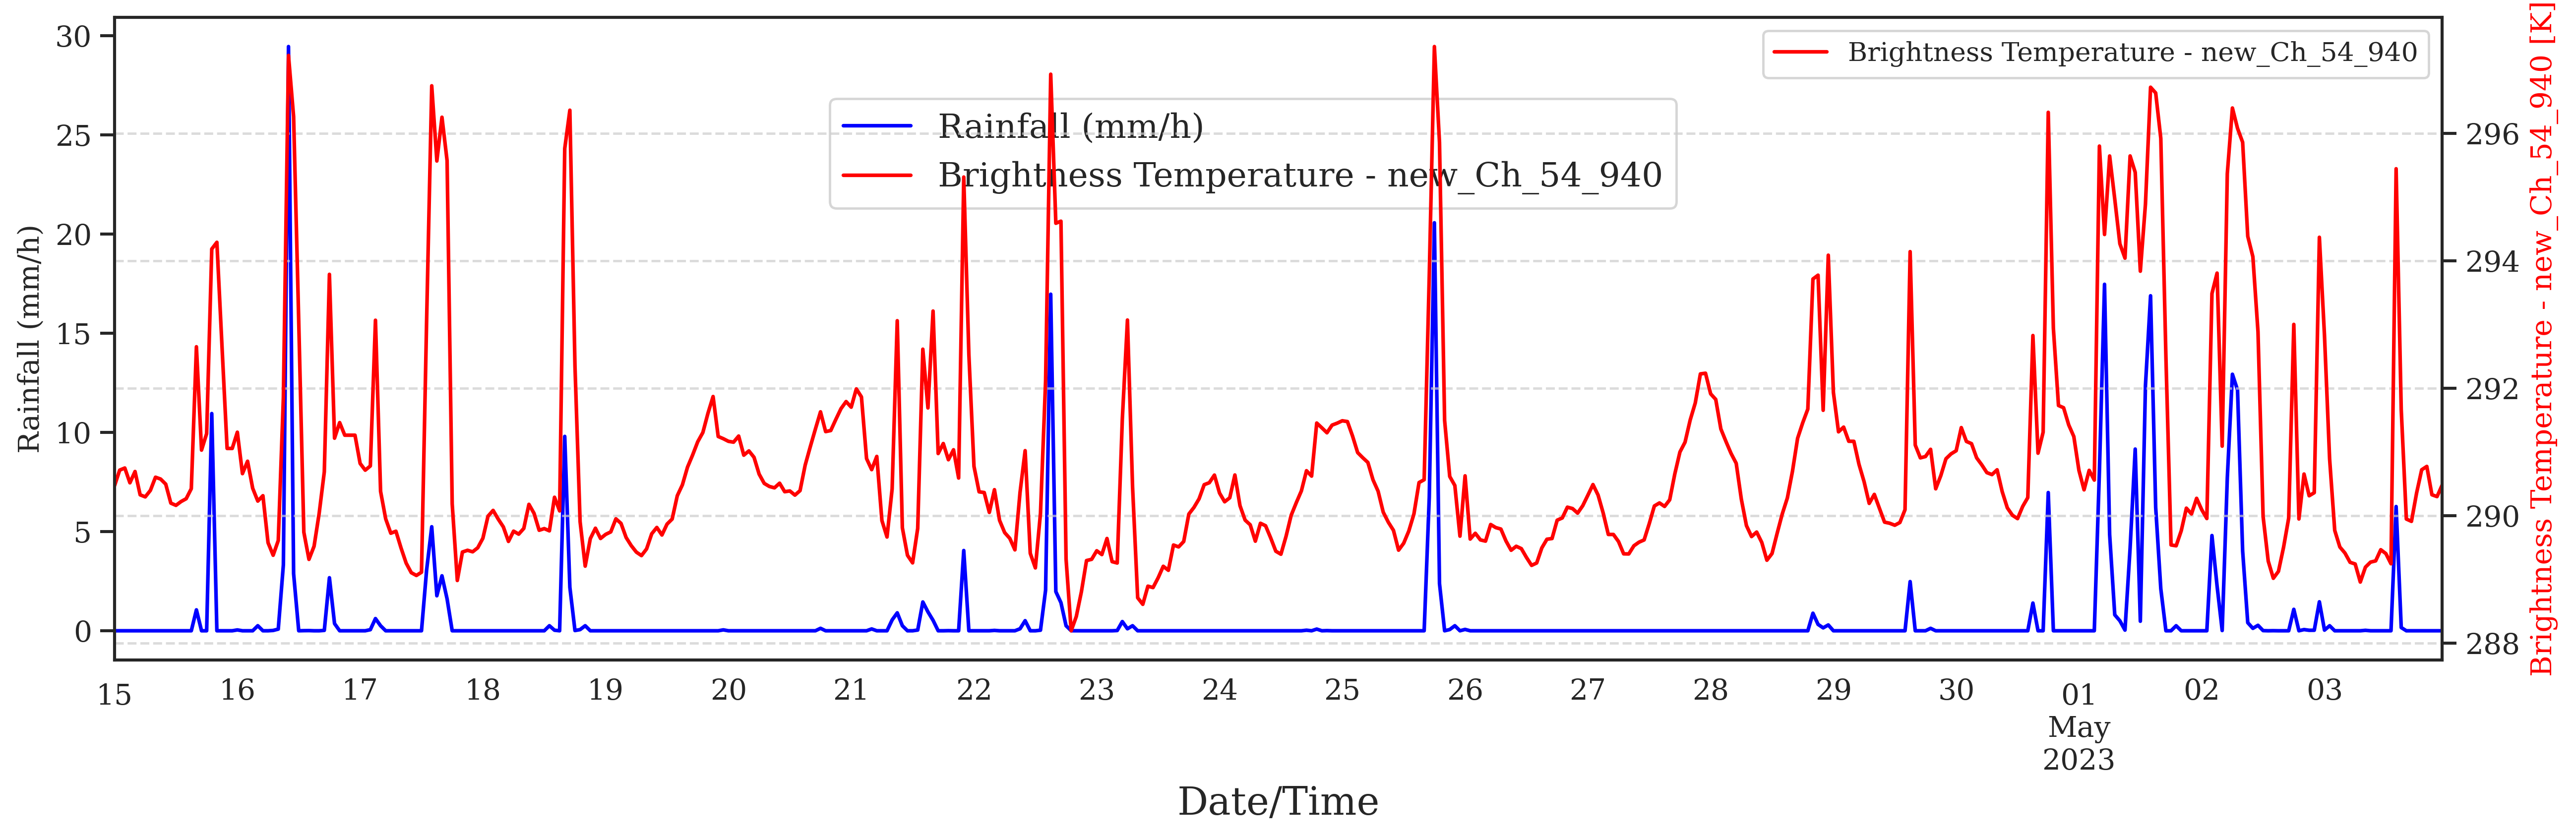

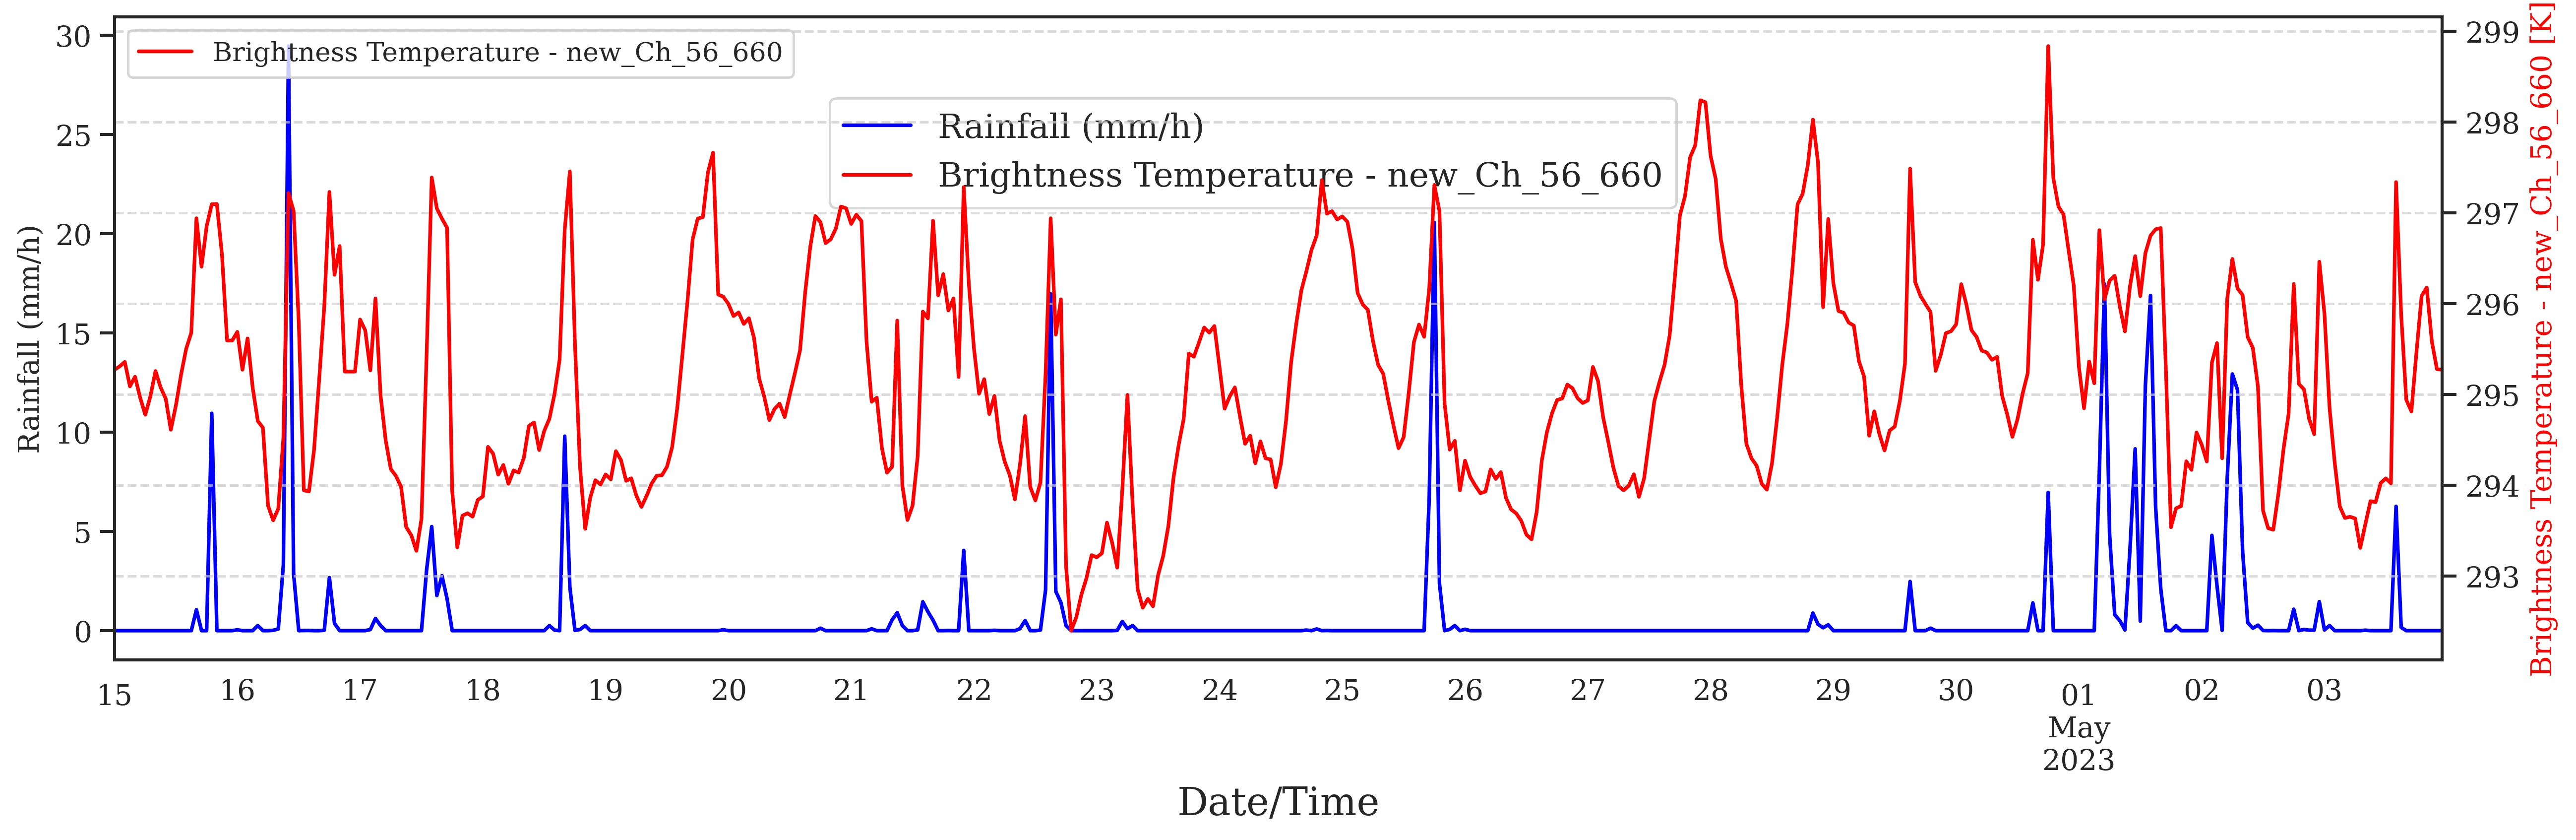

In [90]:
import matplotlib.pyplot as plt

# Definir o intervalo de datas
start_date = '2023-04-15'
end_date = '2023-05-03'

# Filtrar os dados para o período especificado
df_filtered = df_final[start_date:end_date].loc[((df_final['Rainfall_mmh'] >= 0))].copy()

# Lista das variáveis a serem comparadas com Rainfall_mmh
variables = ["new_Ch_22_234", "new_Ch_56_020", "new_Ch_54_940", "new_Ch_56_660"]

# Plot para cada variável da lista
for var in variables:
    fig, ax = plt.subplots(figsize=(15, 5), dpi=350)

    # Plot da chuva
    df_filtered.plot(kind='line', y="Rainfall_mmh", label='Rainfall (mm/h)', linestyle='-', color='blue', ax=ax, fontsize=12)
    ax.set_ylabel('Rainfall (mm/h)', fontsize=12)

    # Criar um segundo eixo y para a variável
    ax2 = ax.twinx()
    df_filtered.plot(kind='line', y=var, label=f'Brightness Temperature - {var}', linestyle='-', ax=ax2, fontsize=12, color='red')
    ax2.set_ylabel(f'Brightness Temperature - {var} [K]', fontsize=12, color='red')

    ax.set_xlabel('Date/Time', fontsize=16)

    # Lidar com as legendas
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.3, 0.9), fontsize=14)

    # Fundo com grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Ajustar layout e exibir o gráfico
    plt.tight_layout()
    plt.show()


In [12]:
df_final.columns

Index(['new_Tamb_k', 'new_Rh_percent', 'new_Pres_mb', 'new_Tir_K',
       'new_Ch_22_234', 'new_Ch_22_500', 'new_Ch_23_034', 'new_Ch_23_834',
       'new_Ch_25_000', 'new_Ch_26_234', 'new_Ch_28_000', 'new_Ch_30_000',
       'new_Ch_51_248', 'new_Ch_51_760', 'new_Ch_52_280', 'new_Ch_52_804',
       'new_Ch_53_336', 'new_Ch_53_848', 'new_Ch_54_400', 'new_Ch_54_940',
       'new_Ch_55_500', 'new_Ch_56_020', 'new_Ch_56_660', 'new_Ch_57_288',
       'new_Ch_57_964', 'new_Ch_58_800', 'Mask_RR_mm_min', 'Rainfall_mmh'],
      dtype='object')

### Definição das **features** a partir das observaçõe nas correlações das variaveis.

In [13]:
variables = ['new_Tir_K', 'new_Ch_22_500', 'new_Ch_51_760', 'new_Ch_56_020', 'new_Ch_56_660', 'new_Ch_54_940']
for variable in variables:
    df_final[f'{variable}_t1'] = df_final[variable].shift(+1) #(1h atrás)
    df_final[f'{variable}_t2'] = df_final[variable].shift(+2) #(2h atrás)
    df_final[f'{variable}_t3'] = df_final[variable].shift(+3) #(3h atrás)
    df_final[f'{variable}_t4'] = df_final[variable].shift(+4) #(4h atrás)
    df_final[f'{variable}_t5'] = df_final[variable].shift(+5) #(5h atrás)
    df_final[f'{variable}_t6'] = df_final[variable].shift(+5) #(6h atrás)
#df_filter_for_model = df_final.iloc[:-3].copy()

#df_filter_for_model[['Rainfall_mm_h', 'Rainfall_mm_h_t1']].loc[((df_filter_for_model['Rainfall_mm_h'] >= 0.1))].head(n=10)
print('Execução do código concluída.')

Execução do código concluída.


### Definição da variável de previsão (**target**)

Primeiramente, vamos preparar os dados para a modelagem, criando uma nova coluna que representa a precipitação uma hora à frente. Essa nova coluna será utilizada como variável de previsão (**target**). Em seguida, filtraremos os dados para focar apenas nos momentos em que há precipitação, e vamos visualizar as primeiras 10 instâncias desses eventos para confirmar se os dados foram deslocados corretamente.e.

In [14]:
variables = ['Rainfall_mmh']
for variable in variables:
    df_final[f'{variable}_t1'] = df_final[variable].shift(-1) #(1h à frente)


#df_filter_for_model[['Rainfall_mm_h', 'Rainfall_mm_h_t1']].loc[((df_filter_for_model['Rainfall_mm_h'] >= 0.1))].head(n=10)
print('Execução do código concluída.')

Execução do código concluída.


In [15]:
df_filter_for_model = df_final.drop(df_final.index[:6]).copy()
df_filter_for_model_full = df_filter_for_model.iloc[:-2].copy()

print('Execução do código concluída.')

Execução do código concluída.


In [16]:
# Usando .isna() ou .isnull() para criar uma máscara de valores NaN
nan_mask = df_filter_for_model_full.isna()

# Usando .sum() para contar os valores True (NaN) em cada coluna
nan_count = nan_mask.sum()

# nan_count agora contém o número de NaN em cada coluna
print(nan_count)

print('Execução do código concluída.')


new_Tamb_k          0
new_Rh_percent      0
new_Pres_mb         0
new_Tir_K           0
new_Ch_22_234       0
                   ..
new_Ch_54_940_t3    0
new_Ch_54_940_t4    0
new_Ch_54_940_t5    0
new_Ch_54_940_t6    0
Rainfall_mmh_t1     0
Length: 65, dtype: int64
Execução do código concluída.


In [17]:
df_filter_for_model_full.Rainfall_mmh_t1

Datetime
2021-07-28 00:00:00    0.0
2021-07-28 01:00:00    0.0
2021-07-28 02:00:00    0.0
2021-07-28 03:00:00    0.0
2021-07-28 04:00:00    0.0
                      ... 
2023-11-27 03:00:00    0.0
2023-11-27 04:00:00    0.0
2023-11-27 05:00:00    0.0
2023-11-27 06:00:00    0.0
2023-11-27 07:00:00    0.0
Name: Rainfall_mmh_t1, Length: 20456, dtype: float64

In [18]:
df_filter_for_model = df_filter_for_model_full.copy()
print('Execução do código concluída.')

Execução do código concluída.


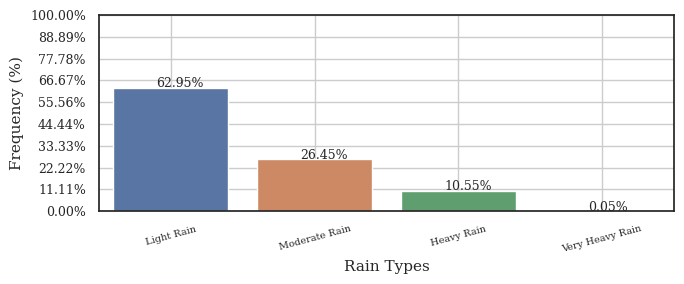

Rain_intensity
1    1354
2     569
3     227
4       1
Name: count, dtype: int64


In [91]:
# Add the 'Class_Rain' column to the DataFrame
df_filter_for_model['Rain_intensity'] = 0

for index, row in df_filter_for_model.iterrows():

    if (row['Rainfall_mmh_t1'] >= 0.1) and (row['Rainfall_mmh_t1'] < 2.5):
        df_filter_for_model.loc[index, 'Rain_intensity'] = 1  # Light rain (Chuva fraca)

    elif (row['Rainfall_mmh_t1'] >= 2.5) and (row['Rainfall_mmh_t1'] <= 10):
        df_filter_for_model.loc[index, 'Rain_intensity'] = 2  # Moderate rain (Chuva moderada)

    elif (row['Rainfall_mmh_t1'] > 10) and (row['Rainfall_mmh_t1'] <= 50):
        df_filter_for_model.loc[index, 'Rain_intensity'] = 3  # Heavy rain (Chuva forte)

    elif (row['Rainfall_mmh_t1'] > 50):
        df_filter_for_model.loc[index, 'Rain_intensity'] = 4  # Very heavy rain (Chuva muito forte)

    else:
        df_filter_for_model.loc[index, 'Rain_intensity'] = 0  # No rain (Sem chuva)




# Filtrar o DataFrame para incluir somente as classes 1, 2, 3 e 4
df_filtered_classes = df_filter_for_model.loc[df_filter_for_model['Rain_intensity'].isin([1, 2, 3, 4])]

# Atualizar o total para o conjunto filtrado
total_filtered = len(df_filtered_classes)

# Criar os subgráficos
fig, axs = plt.subplots(1, 1, figsize=(7, 3))

# Gráfico para as classes filtradas
sns.countplot(x='Rain_intensity', data=df_filtered_classes, ax=axs)
for p in axs.patches:
    axs.annotate('{:.2f}%'.format(100 * p.get_height() / total_filtered), 
                 (p.get_x() + 0.3, p.get_height() + 5), fontsize=9)

axs.set_yticks(np.linspace(0, total_filtered, 10))  # Definir os ticks explicitamente
axs.set_yticklabels(['{:.2f}%'.format(100 * tick / total_filtered) for tick in axs.get_yticks()], fontsize=9)

axs.set_xlabel('Rain Types', fontsize=11)
axs.set_ylabel('Frequency (%)', fontsize=11)
axs.set_xticks([0, 1, 2, 3])  # Garantir que temos somente 4 categorias
axs.set_xticklabels(['Light Rain', 'Moderate Rain', 'Heavy Rain', 'Very Heavy Rain'], rotation=15, fontsize=7)
axs.grid()

# Ajustar o layout e exibir o gráfico
plt.tight_layout()
plt.show()

# Exibir contagem de valores para as classes filtradas
print(df_filtered_classes['Rain_intensity'].value_counts())

In [22]:
# Selecting the features and the target

features = ['new_Ch_22_234','new_Ch_30_000','new_Ch_56_660','new_Ch_58_800','new_Ch_56_020','new_Ch_57_964','new_Ch_53_848']
#features = ['new_Ch_54_940', 'new_Ch_56_020', 'new_Ch_56_660', 'new_Ch_57_288']
#"new_Ch_57_288", "new_Ch_56_020", "new_Ch_54_940", "new_Ch_56_660"

target = 'Rainfall_mmh_t1'

print('Execução do código concluída.')

Execução do código concluída.


In [23]:
df_filter_for_model_copy = df_filter_for_model.copy()
print('Execução do código concluída.')

Execução do código concluída.


In [24]:
# Filtrar os dados para o período especificado para usar separadamente em treino e testes separado do modelo

data_final = '2023-10-01'
df_final_for_training = df_filter_for_model_copy[:data_final].copy()

data_inicio = '2023-10-02'
df_for_tests_aditionals = df_filter_for_model_copy[data_inicio:].copy()

print('Execução do código concluída.')

Execução do código concluída.


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Filtrar o dataset
Dataset_T0 = df_filter_for_model.loc[
    (df_filter_for_model['Rainfall_mmh_t1'] >= 0)
].copy()

# Separar as features e o alvo
a = Dataset_T0[features]
b = Dataset_T0[target]

# Dividir os dados em treino e conjunto temporário (validação + teste)
X_train_0, X_temp, y_train_0, y_temp = train_test_split(a, b, test_size=0.3, random_state=42)

# Dividir o conjunto temporário em validação e teste
X_val_0, X_test_0, y_val_0, y_test_0 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalizar os dados (usando somente estatísticas do conjunto de treinamento)
scaler = StandardScaler()
X_train_0 = scaler.fit_transform(X_train_0)  # Fit e transform no treinamento
X_val_0 = scaler.transform(X_val_0)         # Transform na validação
X_test_0 = scaler.transform(X_test_0)       # Transform no teste

# Função para contar eventos de chuva >= 0.1
def count_events(data):
    return (data >= 0.1).sum()

# Contar eventos em cada conjunto
train_events = count_events(y_train_0)
val_events = count_events(y_val_0)
test_events = count_events(y_test_0)

# Imprimir informações dos conjuntos de dados
print("CONJUNTO DE DADOS PARA TREINAMENTO:")
print(f"Inicial: {y_train_0.index.min()}, Final: {y_train_0.index.max()}")
print(f"Número de eventos de chuva >= 0.1 mm/h: {train_events}")

print("\nCONJUNTO DE DADOS PARA VALIDAÇÃO:")
print(f"Inicial: {y_val_0.index.min()}, Final: {y_val_0.index.max()}")
print(f"Número de eventos de chuva >= 0.1 mm/h: {val_events}")

print("\nCONJUNTO DE DADOS PARA TESTES:")
print(f"Inicial: {y_test_0.index.min()}, Final: {y_test_0.index.max()}")
print(f"Número de eventos de chuva >= 0.1 mm/h: {test_events}")




CONJUNTO DE DADOS PARA TREINAMENTO:
Inicial: 2021-07-28 01:00:00, Final: 2023-11-27 07:00:00
Número de eventos de chuva >= 0.1 mm/h: 1511

CONJUNTO DE DADOS PARA VALIDAÇÃO:
Inicial: 2021-07-28 00:00:00, Final: 2023-11-27 06:00:00
Número de eventos de chuva >= 0.1 mm/h: 332

CONJUNTO DE DADOS PARA TESTES:
Inicial: 2021-07-29 14:00:00, Final: 2023-11-27 03:00:00
Número de eventos de chuva >= 0.1 mm/h: 308


### Funções para calcular POD, FAR, e as outras métricas considerando apenas as classes de chuva mais relevantes pata nosso problema ('Light Rain', 'Moderate Rain', 'Heavy Rain', 'Very Heavy Rain') em vez de todas as previsões.


1. **POD** responde: "**Quão bem o modelo detecta eventos que realmente ocorreram?**"
2. **FAR** responde: "**Quão frequentemente o modelo erra ao prever eventos que não acontecem?**"


In [26]:
def calculate_pod(true_positives, false_negatives):
    return true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

def calculate_far(false_positives, true_positives):
    return false_positives / (false_positives + true_positives) if (false_positives + true_positives) > 0 else 0

def get_dynamic_interpretation(pod, far):
    if pod >= 0.8 and far <= 0.2:
        return "Alta detecção, baixos falsos alarmes."
    elif pod >= 0.6 and far <= 0.4:
        return "Boa detecção, moderados falsos alarmes."
    elif pod >= 0.4 and far <= 0.6:
        return "Detecção razoável, falsos alarmes significativos."
    return "Baixa detecção e/ou altos falsos alarmes."

def evaluate_and_get_results(y_test, y_pred, dataset_name):
    rain_classes = {
        "Light Rain": [0.1, 2.5],
        "Moderate Rain": [2.5, 10],
        "Heavy Rain": [10, 50],
        "Very Heavy Rain": [50, float('inf')]
    }

    # Filtrar classes apenas dentro das faixas relevantes
    y_test_filtered = []
    y_pred_filtered = []

    for observed, predicted in zip(y_test, y_pred):
        for rain_class, thresholds in rain_classes.items():
            if thresholds[0] <= observed < thresholds[1]:
                y_test_filtered.append(observed)
                y_pred_filtered.append(predicted)
                break

    class_counts = {rain_class: {"true_positives": 0, "false_positives": 0, "false_negatives": 0, "total": 0} 
                    for rain_class in rain_classes}

    for observed, predicted in zip(y_test_filtered, y_pred_filtered):
        observed_class = next((cls for cls, rng in rain_classes.items() if rng[0] <= observed < rng[1]), None)
        predicted_class = next((cls for cls, rng in rain_classes.items() if rng[0] <= predicted < rng[1]), None)

        if observed_class:
            class_counts[observed_class]["total"] += 1

        if observed_class and predicted_class:
            if observed_class == predicted_class:
                class_counts[observed_class]["true_positives"] += 1
            else:
                class_counts[observed_class]["false_negatives"] += 1
                class_counts[predicted_class]["false_positives"] += 1

    results = []
    for rain_class, counts in class_counts.items():
        pod = calculate_pod(counts["true_positives"], counts["false_negatives"])
        far = calculate_far(counts["false_positives"], counts["true_positives"])
        dynamic_interpretation = get_dynamic_interpretation(pod, far)

        results.append([rain_class, pod, far, dynamic_interpretation])

    # Métricas totais
    total_true_positives = sum(c["true_positives"] for c in class_counts.values())
    total_false_positives = sum(c["false_positives"] for c in class_counts.values())
    total_false_negatives = sum(c["false_negatives"] for c in class_counts.values())

    total_pod = calculate_pod(total_true_positives, total_false_negatives)
    total_far = calculate_far(total_false_positives, total_true_positives)
    total_interpretation = get_dynamic_interpretation(total_pod, total_far)

    results.append(["Overall", total_pod, total_far, total_interpretation])
    return results

def print_results_table(results):
    print(f"{'Rain Class':<25} {'POD':<10} {'FAR':<10} {'Interpretação':<40}")
    print("=" * 80)
    for row in results:
        print(f"{row[0]:<25} {row[1]:<10.2f} {row[2]:<10.2f} {row[3]:<40}")

print('Execução do código concluída.')

Execução do código concluída.


### Agora que conhecemos a dsitribuição das intensidades das chuvas, vamos calcular os pesos a serem aplicados pelo modelo às amostras durante o treinamento.

Os pesos das amostras são calculados com base nas frequências das classes no conjunto de dados. Classes menos frequentes recebem pesos mais altos, enquanto classes mais frequentes recebem pesos mais baixos. Isso é feito para equilibrar o impacto das classes durante o treinamento de um modelo, permitindo que ele dê mais atenção às classes minoritárias e, assim, melhorar o desempenho em cenários de desbalanceamento de dados. Essa abordagem ajuda o modelo a fazer previsões mais precisas para todas as classes, independentemente de sua representação no conjunto de dados.

In [74]:
# Função para calcular pesos de amostras
def calculate_sample_weights(y_train, selected_classes=None, custom_weights=None, total_weight=1):
    # Converter y_train para um DataFrame para facilitar manipulação
    df = y_train.to_frame(name='Rainfall_mmh_t1')
    df['Rain_intensity'] = 0 #(No Rain)  # Adicionar uma coluna para categorizar intensidade de chuva

    # Categorizar as amostras com base em valores de precipitação
    for index, row in df.iterrows():
        if (row['Rainfall_mmh_t1'] >= 0.1) and (row['Rainfall_mmh_t1'] < 2.5):
            df.loc[index, 'Rain_intensity'] = 1  # Light rain
        elif (row['Rainfall_mmh_t1'] >= 2.5) and (row['Rainfall_mmh_t1'] <= 10):
            df.loc[index, 'Rain_intensity'] = 2  # Moderate rain
        elif (row['Rainfall_mmh_t1'] > 10) and (row['Rainfall_mmh_t1'] <= 50):
            df.loc[index, 'Rain_intensity'] = 3  # Heavy rain
        elif (row['Rainfall_mmh_t1'] > 50):
            df.loc[index, 'Rain_intensity'] = 4  # Very heavy rain
        else:
            df.loc[index, 'Rain_intensity'] = 0 # No rain (Sem chuva)

    # Calcular frequências e pesos baseados nas classes
    class_counts = df['Rain_intensity'].value_counts()  # Frequência absoluta
    class_frequencies = class_counts / len(df)  # Frequência relativa
    class_weights = 1 / class_frequencies  # Inverte as frequências para calcular pesos

    # Caso tenha classes selecionadas
    if selected_classes is not None:
        # Aplica os pesos apenas nas classes selecionadas e 1 para as não selecionadas
        sample_weights = df['Rain_intensity'].apply(
            lambda x: class_weights[x] if x in selected_classes else 1)
    else:
        # Se nenhuma classe for especificada, atribui peso 1 para todas as classes
        sample_weights = pd.Series(1, index=df.index)

    # Normalizar os pesos para que a soma seja igual a `total_weight`
    #sample_weights = sample_weights / sample_weights.sum() * total_weight

    # Aplicar multiplicadores personalizados, se fornecidos
    if custom_weights:
        sample_weights = sample_weights * custom_weights

    # Retornar os pesos como array NumPy
    return sample_weights.values


print('Execução do código concluída.')

Execução do código concluída.


# Definições do Modelo LSTM

Primeiramente, vamos usar o Optuna para encontar a melhor arquitetura e hiperparâmetros para a LSTM, como base em limiares que descobrimos com configurações manuais

**Otimização de hiperparâmetros com Optuna**

In [75]:
# Importação das bibliotecas necessárias
import optuna  # Para otimização de hiperparâmetros
import matplotlib.pyplot as plt  # Para visualização de gráficos
from sklearn.preprocessing import StandardScaler  # Para normalização de dados
from keras.models import Sequential  # Para criação de modelos sequenciais de redes neurais
from keras.layers import LSTM, Dense, Dropout  # Camadas de LSTM, densas e dropout para o modelo
from tensorflow.keras import Input  # Para especificar a entrada do modelo
from sklearn.metrics import mean_squared_error  # Para calcular o erro médio quadrático (RMSE)
from tensorflow.keras.optimizers import Adam

# Função para preparar os dados no formato necessário para redes LSTM
def create_lstm_data(X, y, time_steps):
    """
    Converte dados tabulares em sequências para uso em redes LSTM.
    Cada entrada será composta por `time_steps` observações consecutivas.

    Parâmetros:
    - X: DataFrame ou array com os dados de entrada.
    - y: DataFrame ou Series com os rótulos correspondentes.
    - time_steps: Número de passos de tempo a considerar para cada amostra.

    Retorno:
    - X_lstm: Array com as sequências para entrada no modelo LSTM.
    - y_lstm: Array com os rótulos correspondentes.
    """
    X_lstm, y_lstm = [], []
    for i in range(time_steps, len(X)):
        X_lstm.append(X[i - time_steps:i])
        y_lstm.append(y.iloc[i])  # `.iloc` é usado para acessar a posição exata no DataFrame
    return np.array(X_lstm), np.array(y_lstm)

# Função para criar um modelo LSTM com camadas configuráveis
def create_lstm_model_variable_layers(input_shape, num_layers=1, lstm_units=None, dropout_rate=None):
    """
    Cria um modelo LSTM com número variável de camadas, unidades e taxas de dropout.

    Parâmetros:
    - input_shape: Dimensão da entrada no formato (time_steps, features).
    - num_layers: Número de camadas LSTM no modelo.
    - lstm_units: Lista com o número de unidades em cada camada LSTM.
    - dropout_rate: Lista com a taxa de dropout para cada camada LSTM.

    Retorno:
    - model: Modelo compilado pronto para treino.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))  # Define a entrada do modelo

    for i in range(num_layers):
        return_sequences = i < (num_layers - 1)  # Apenas camadas intermediárias retornam sequências
        model.add(LSTM(units=lstm_units[i], return_sequences=return_sequences, stateful=False))
        model.add(Dropout(dropout_rate[i]))  # Aplica dropout para reduzir overfitting

    model.add(Dense(1))  # Camada de saída para regressão
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])  # Configura o modelo #loss='mean_squared_error'
    return model

# Função objetivo para o Optuna otimizar
def objective(trial):
    """
    Função objetivo para otimizar os hiperparâmetros do modelo LSTM com Optuna.

    Parâmetros:
    - trial: Instância do Optuna para sugerir valores de hiperparâmetros.

    Retorno:
    - val_loss: Perda de validação do modelo no final do treinamento.
    """
    time_steps = 4  # Número de passos de tempo a considerar em cada entrada

    # Hiperparâmetros a serem otimizados
    num_layers = trial.suggest_int('num_layers', 1, 2)  # Número de camadas LSTM
    lstm_units = [trial.suggest_int(f'lstm_units_layer_{i+1}', 50, 200) for i in range(num_layers)]  # Neurônios em cada camada
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    dropout_rate = [trial.suggest_float(f'dropout_rate_layer_{i+1}', 0.15, 0.5) for i in range(num_layers)]  # Taxas de dropout
    epochs = trial.suggest_int('epochs', 20, 100)  # Número de épocas
    batch_size = trial.suggest_int('batch_size', 16, 128, step=16)  # Tamanho do batch

    # Prepara os dados de treinamento e validação no formato LSTM
    X_train_lstm, y_train_lstm = create_lstm_data(X_train_0, y_train_0, time_steps)
    X_val_lstm, y_val_lstm = create_lstm_data(X_val_0, y_val_0, time_steps)

    # Calcula pesos para amostras específicas
    selected_classes = [0,1,2,3,4]  # Foco em classes específicas
    sample_weights_train = calculate_sample_weights(y_train_0[time_steps:], selected_classes=selected_classes)

    # Cria e treina o modelo
    model = create_lstm_model_variable_layers(
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
        num_layers=num_layers,
        lstm_units=lstm_units,
        dropout_rate=dropout_rate
    )

    # Treinamento do modelo
    history = model.fit(
        X_train_lstm, y_train_lstm,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_lstm, y_val_lstm),
        sample_weight=sample_weights_train,
        verbose=0
    )

    val_loss = history.history['val_loss'][-1]  # Última perda de validação
    return val_loss

# Otimização com Optuna
study = optuna.create_study(direction='minimize')  # Direção: minimizar a perda
study.optimize(objective, n_trials=10)  # Realiza 10 execuções para encontrar os melhores hiperparâmetros

# Exibe os melhores hiperparâmetros encontrados
print("Melhor ensaio encontrado com o Optuna para a LSTM:")
trial = study.best_trial
print(f"  Valor do melhor ensaio: {trial.value}")
print("  Parâmetros encontrados:")
for key, value in trial.params.items():
    print(f"    - {key}: {value}")


[I 2024-12-10 17:36:04,918] A new study created in memory with name: no-name-34569056-252d-4685-bcbb-768e6f2c1860
[I 2024-12-10 17:37:37,463] Trial 0 finished with value: 18.915647506713867 and parameters: {'num_layers': 1, 'lstm_units_layer_1': 183, 'learning_rate': 1.0498196762222404e-05, 'dropout_rate_layer_1': 0.2848211297850656, 'epochs': 79, 'batch_size': 48}. Best is trial 0 with value: 18.915647506713867.
[I 2024-12-10 17:37:58,505] Trial 1 finished with value: 24.729206085205078 and parameters: {'num_layers': 2, 'lstm_units_layer_1': 196, 'lstm_units_layer_2': 188, 'learning_rate': 0.000313447291319916, 'dropout_rate_layer_1': 0.4363612835818148, 'dropout_rate_layer_2': 0.3030614959202007, 'epochs': 24, 'batch_size': 112}. Best is trial 0 with value: 18.915647506713867.
[I 2024-12-10 17:38:45,634] Trial 2 finished with value: 34.692928314208984 and parameters: {'num_layers': 2, 'lstm_units_layer_1': 106, 'lstm_units_layer_2': 185, 'learning_rate': 1.0070211096675745e-05, 'drop

Melhor ensaio encontrado com o Optuna para a LSTM:
  Valor do melhor ensaio: 14.886934280395508
  Parâmetros encontrados:
    - num_layers: 2
    - lstm_units_layer_1: 197
    - lstm_units_layer_2: 137
    - learning_rate: 0.008347507093420687
    - dropout_rate_layer_1: 0.3134644788740151
    - dropout_rate_layer_2: 0.34785400889653917
    - epochs: 83
    - batch_size: 48


## Agora vamos treinar o modelo LSTM aplicando os melhores hiperparâmetros encontrados
Nesta etapa, utilizaremos os melhores hiperparâmetros identificados durante o processo de otimização com Optuna para treinar o modelo LSTM. Isso garantirá que o modelo esteja configurado com parâmetros otimizados, como o número de camadas, neurônios em cada camada, taxas de dropout, número de épocas e tamanho do batch. Ao aplicar esses valores ideais, esperamos maximizar o desempenho do modelo, minimizando a perda de validação e melhorando a precisão das predições sobre os dados de teste.

In [76]:
import os
from tensorflow.keras.callbacks import EarlyStopping

# Definindo o diretório de trabalho
working_dir = '/kaggle/working/FinalProj_DeepLearning_dir'

# Criando o diretório caso ele não exista
os.makedirs(working_dir, exist_ok=True)

# Mudando o diretório de trabalho para o diretório criado
os.chdir(working_dir)

print(f"Diretório de trabalho configurado: {os.getcwd()}")


# Função para treinar e avaliar o modelo
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, input_shape, best_params, use_weights=False, sample_weights=None):
    """
    Treina e avalia um modelo LSTM com base nos melhores hiperparâmetros encontrados.

    Parâmetros:
    - X_train, y_train: Dados de treinamento.
    - X_val, y_val: Dados de validação.
    - X_test, y_test: Dados de teste.
    - input_shape: Formato da entrada no modelo LSTM (time_steps, features).
    - best_params: Dicionário com os melhores hiperparâmetros obtidos pelo Optuna.
    - use_weights: Se True, utiliza pesos nas amostras para o treinamento.
    - sample_weights: Array com os pesos das amostras, caso use_weights seja True.

    Retorno:
    - model: Modelo treinado.
    - history: Histórico do treinamento.
    - rmse: Erro quadrático médio raiz nos dados de teste.
    - y_pred: Predições do modelo nos dados de teste.
    """
    # Criação do modelo usando os hiperparâmetros ótimos
    model = create_lstm_model_variable_layers(
        input_shape=input_shape,
        num_layers=best_params['num_layers'],
        lstm_units=[best_params[f'lstm_units_layer_{i+1}'] for i in range(best_params['num_layers'])],
        dropout_rate=[best_params[f'dropout_rate_layer_{i+1}'] for i in range(best_params['num_layers'])]
    )

    # Configuração do EarlyStopping
    early_stopping = EarlyStopping(
        monitor='val_loss',      # Monitorar a perda de validação
        patience=25,             # Número de épocas sem melhoria para parar o treinamento
        restore_best_weights=True # Restaurar os melhores pesos do modelo
    )

    # Treinamento do modelo com EarlyStopping
    if use_weights and sample_weights is not None:
        history = model.fit(
            X_train, y_train,
            epochs=best_params['epochs'],
            batch_size=best_params['batch_size'],
            validation_data=(X_val, y_val),
            sample_weight=sample_weights,
            verbose=1
            #callbacks=[early_stopping]  # Adiciona o callback EarlyStopping
        )
    else:
        history = model.fit(
            X_train, y_train,
            epochs=best_params['epochs'],
            batch_size=best_params['batch_size'],
            validation_data=(X_val, y_val),
            verbose=1
            #callbacks=[early_stopping]  # Adiciona o callback EarlyStopping
        )

    # Avaliação do modelo
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

    # Predições e cálculo do RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Test RMSE: {rmse}")

    return model, history, rmse, y_pred


# Preparação dos dados LSTM
time_steps = 6  # Número de passos de tempo a considerar

# Criando os dados LSTM para treinamento, validação e teste
X_train_lstm, y_train_lstm = create_lstm_data(X_train_0, y_train_0, time_steps)
X_val_lstm, y_val_lstm = create_lstm_data(X_val_0, y_val_0, time_steps)
X_test_lstm, y_test_lstm = create_lstm_data(X_test_0, y_test_0, time_steps)

# Verificando os formatos dos dados
print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")
print(f"X_val_lstm shape: {X_val_lstm.shape}")
print(f"y_val_lstm shape: {y_val_lstm.shape}")
print(f"X_test_lstm shape: {X_test_lstm.shape}")
print(f"y_test_lstm shape: {y_test_lstm.shape}")

# Calcular pesos para amostras específicas (se necessário)
selected_classes = [0,1,2,3,4]  # Exemplo de classes de interesse
sample_weights_train = calculate_sample_weights(y_train_0[time_steps:], selected_classes=selected_classes)

# Realizando o treinamento e avaliação com pesos nas amostras
print("Treinamento com pesos nas amostras:")
model_with_weights, history_with_weights, rmse_with_weights, y_pred_with_weights = train_and_evaluate(
    X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, X_test_lstm, y_test_lstm,
    input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
    best_params=trial.params,
    use_weights=True,
    sample_weights=sample_weights_train
)

# Salvando o modelo com pesos
model_with_weights.save("model_LSTM_with_weights.keras")
print("Modelo com pesos salvo como 'model_LSTM_with_weights.keras'")

# Realizando o treinamento e avaliação sem pesos nas amostras
print("Treinamento sem pesos nas amostras:")
model_without_weights, history_without_weights, rmse_without_weights, y_pred_without_weights = train_and_evaluate(
    X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, X_test_lstm, y_test_lstm,
    input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
    best_params=trial.params,
    use_weights=False
)

# Salvando o modelo sem pesos
model_without_weights.save("model_LSTM_without_weights.keras")
print("Modelo sem pesos salvo como 'model_without_weights.keras'")


Diretório de trabalho configurado: /kaggle/working/FinalProj_DeepLearning_dir
X_train_lstm shape: (14313, 6, 7)
y_train_lstm shape: (14313,)
X_val_lstm shape: (3062, 6, 7)
y_val_lstm shape: (3062,)
X_test_lstm shape: (3063, 6, 7)
y_test_lstm shape: (3063,)
Treinamento com pesos nas amostras:
Epoch 1/83
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 250.9335 - mae: 3.6864 - val_loss: 24.2530 - val_mae: 4.7630
Epoch 2/83
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 248.5151 - mae: 5.4219 - val_loss: 28.3940 - val_mae: 5.1835
Epoch 3/83
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 264.5580 - mae: 5.2956 - val_loss: 37.0322 - val_mae: 5.9665
Epoch 4/83
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 247.9890 - mae: 5.8207 - val_loss: 29.8273 - val_mae: 5.3218
Epoch 5/83
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 263.3930 - mae: 5.5507 - val_loss: 29.0885 - val_mae: 5.2478
Epoch 6/83
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 213.4256 - mae: 5.2699 - val_loss: 36.6806

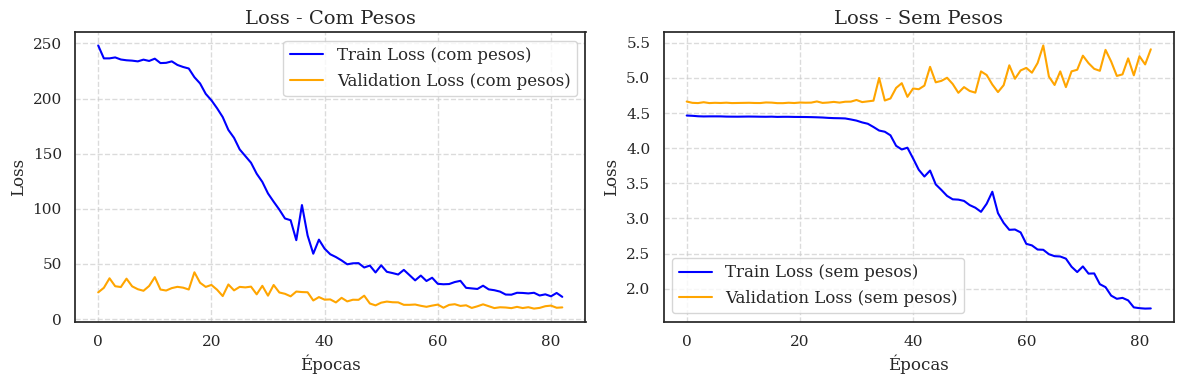

In [77]:
# Comparação de curvas de loss em subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1x2 grid de subplots

# Loss com pesos
axs[0].plot(history_with_weights.history['loss'], label='Train Loss (com pesos)', color='blue')
axs[0].plot(history_with_weights.history['val_loss'], label='Validation Loss (com pesos)', color='orange')
axs[0].set_title('Loss - Com Pesos', fontsize=14)
axs[0].set_xlabel('Épocas', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].legend(fontsize=12)

# Loss sem pesos
axs[1].plot(history_without_weights.history['loss'], label='Train Loss (sem pesos)', color='blue')
axs[1].plot(history_without_weights.history['val_loss'], label='Validation Loss (sem pesos)', color='orange')
axs[1].set_title('Loss - Sem Pesos', fontsize=14)
axs[1].set_xlabel('Épocas', fontsize=12)
axs[1].set_ylabel('Loss', fontsize=12)
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].legend(fontsize=12)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()


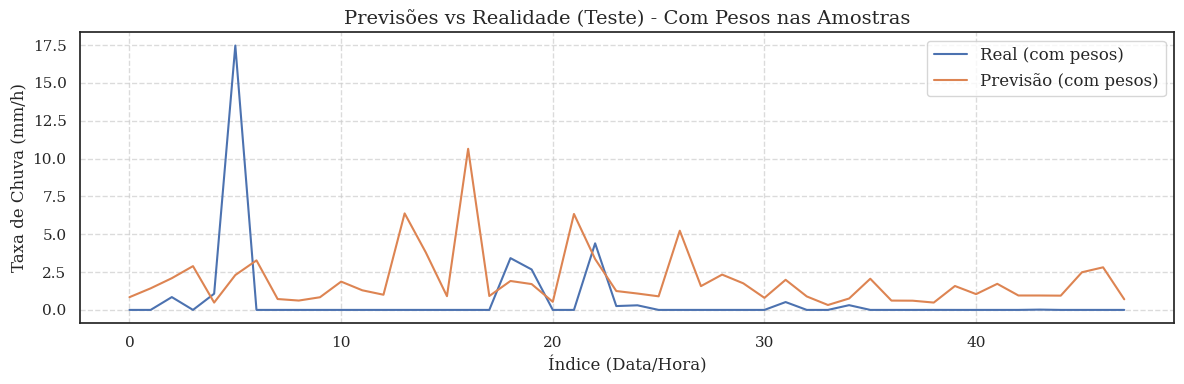

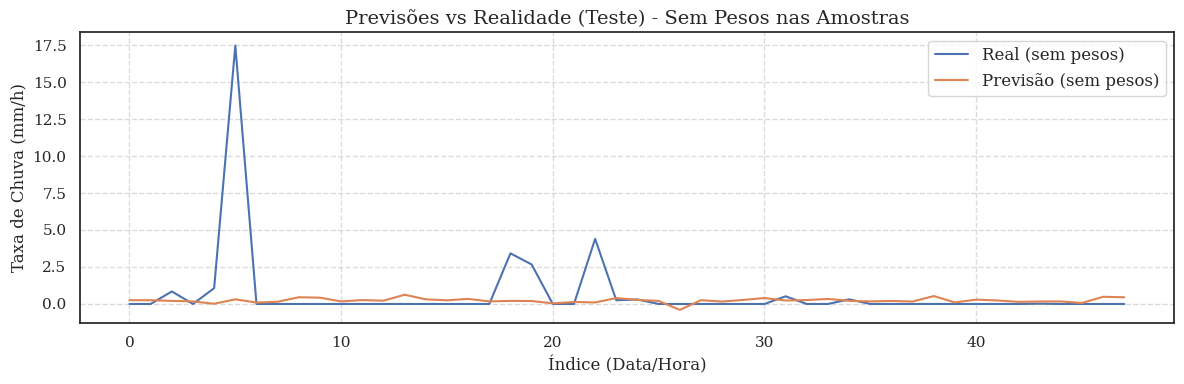

In [94]:
# Visualizar as previsões versus o valor real (com pesos nas amostras)
plt.figure(figsize=(12, 4))
plt.plot(y_test_lstm[:48], label='Real (com pesos)')
plt.plot(y_pred_with_weights[:48], label='Previsão (com pesos)', linestyle='-')
plt.title('Previsões vs Realidade (Teste) - Com Pesos nas Amostras', fontsize=14)
plt.xlabel('Índice (Data/Hora)', fontsize=12)
plt.ylabel('Taxa de Chuva (mm/h)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualizar as previsões versus o valor real (sem pesos nas amostras)
plt.figure(figsize=(12, 4))
plt.plot(y_test_lstm[:48], label='Real (sem pesos)')
plt.plot(y_pred_without_weights[:48], label='Previsão (sem pesos)', linestyle='-')
plt.title('Previsões vs Realidade (Teste) - Sem Pesos nas Amostras', fontsize=14)
plt.xlabel('Índice (Data/Hora)', fontsize=12)
plt.ylabel('Taxa de Chuva (mm/h)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


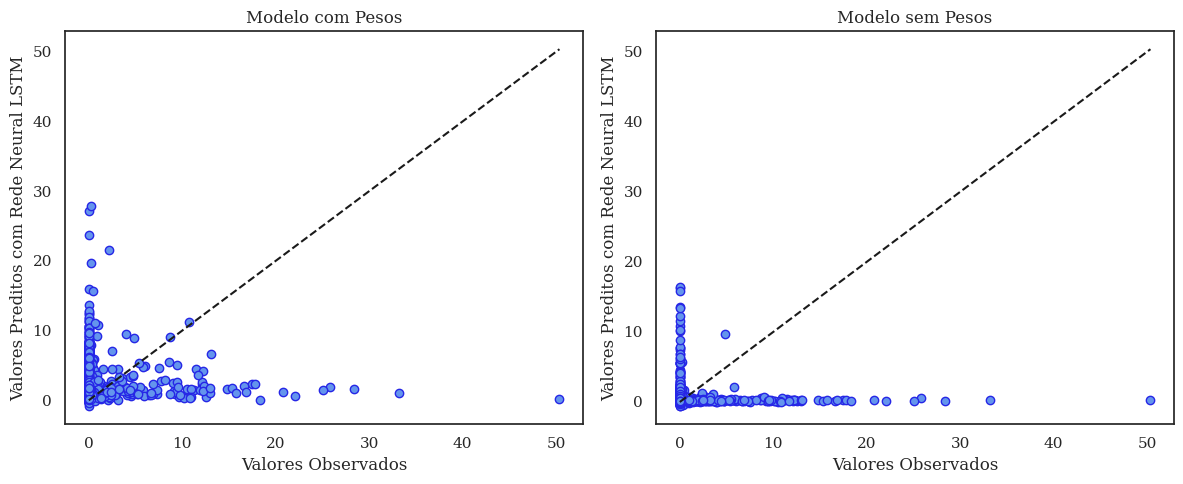

In [80]:
import matplotlib.pyplot as plt

# Criando a figura e o eixo para os gráficos
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotando os resultados do modelo com pesos
axs[0].scatter(y_test_lstm, y_pred_with_weights, color='cornflowerblue', edgecolors=(0.15, 0.15, 0.9))
axs[0].plot([y_test_lstm.min(), y_test_lstm.max()], [y_test_lstm.min(), y_test_lstm.max()], "k--", lw=1.5)
axs[0].set_title('Modelo com Pesos')
axs[0].set_xlabel("Valores Observados")
axs[0].set_ylabel("Valores Preditos com Rede Neural LSTM")

# Plotando os resultados do modelo sem pesos
axs[1].scatter(y_test_lstm, y_pred_without_weights, color='cornflowerblue', edgecolors=(0.15, 0.15, 0.9))
axs[1].plot([y_test_lstm.min(), y_test_lstm.max()], [y_test_lstm.min(), y_test_lstm.max()], "k--", lw=1.5)
axs[1].set_title('Modelo sem Pesos')
axs[1].set_xlabel("Valores Observados")
axs[1].set_ylabel("Valores Preditos com Rede Neural LSTM")

# Ajustando o layout para melhor visualização
plt.tight_layout()
plt.show()


## **Conclusões**

# **Referências**
[1] Meinrat Andreae et al. “**The Amazon Tall Tower Observatory (ATTO): overview of pilot measurements on ecosystem ecology, meteorology, trace gases, and aerosols**”. Em: Atmospheric Chemistry and Physics 15.18 (2015), pp. 10723–10776.

[2] L. J. Cavalcante Neto e A. J Calheiros. “**A study on the impact of data balance on rain fall prediction through artificial neural networks using surface microwave radiometers**”. Em: Latin-American Journal of Computing 11.2 (jul. de 2024), pp. 51–59. url: https: //lajc.epn.edu.ec/index.php/LAJC/article/view/394.

[3] **Radiometrics Corporation. MP3000A Profiler Operator’s Manual**. 2008.

[4] Emad Habib, Witold F Krajewski e Anton Kruger. “**Sampling errors of tipping-bucket raingauge measurements**”. Em: Journal of Hydrologic Engineering 6.2 (2001), pp. 159–166.

[5] S Hochreiter. “**Long Short-term Memory”. Em: Neural Computation MIT-Press (1997)**.

[6] Tanvir Islam, Miguel A Rico-Ramirez, Dawei Han e Prashant K Srivastava. “**A Joss–Waldvogel disdrometer derived rainfall estimation study by collocated tipping bucket and rapid response rain gauges**”. Em: Atmospheric Science Letters 13.2 (2012), pp. 139–150.

[7] Martin Löffler-Mang e Jürg Joss. “**An optical disdrometer for measuring size and velocity of hydrometeors**”. Em: Journal of Atmospheric and Oceanic Technology 17.2 (2000), pp. 130–139.

[8] Qinghua Miao, Baoxiang Pan, Hao Wang, Kuolin Hsu e Soroosh Sorooshian. “**Improving monsoon precipitation prediction using combined convolutional and long short term memory neural network**”. Em: Water 11.5 (2019), p. 977.

[9] **WORLD METEOROLOGICAL ORGANIZATION (WMO). Guide to meteorological instruments and methods of observation**. 7th ed. ed. Geneva, Switzerland: World Meteorological Organization, 2008. OCLC: 288915903. ISBN 978-92-63-10008-5. 11, 12, 65, 66

---

[chollet2018] **Deep Learning with Phyton**. François Chollet. https://livebook.manning.com/book/deep-learning-with-python/

[goodfellow2016] **The Deep Learning Book**. Ian Goodfellow, Yoshua Bengio, Aaron Courville. https://www.deeplearningbook.org/

[graves2012] **Supervised Sequence Labelling with Recurrent Neural Networks**. Alex Graves.

[simplernn2021] **Understanding Simple Recurrent Neural Networks In Keras**. https://machinelearningmastery.com/start-here/

[karpathy2015] **The Unreasonable Effectiveness of Recurrent Neural Networks**. https://karpathy.github.io/2015/05/21/rnn-effectiveness/

[hochreiter1997] **Long Short-Term Memory**, Sepp Hochreiter, Jurgen Schmidhuber. http://www.bioinf.jku.at/publications/older/2604.pdf


[colah2015] **Understanding LSTM Networks**. http://colah.github.io/posts/2015-08-Understanding-LSTMs/

[chung2014] **Empirical Evaluation of Gated Recurrent Neural  Networks on Sequence Modeling**. Junyoung Chung, Caglar Gulcehre, KyungHyun Cho, Yoshua Bengio. https://arxiv.org/pdf/1412.3555.pdfnt Descent,” 2012.